### JOB ANALYZER

Загрузка библиотек

In [1]:
import requests
import regex
import json
import time
from pathlib import Path
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import itertools
from itertools import chain, combinations

import warnings
warnings.simplefilter('ignore')

import re
import nltk

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from tqdm.autonotebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# import gensim.downloader as api
# from gensim.models import WordEmbeddingSimilarityIndex
# from gensim.corpora import Dictionary
# from gensim.models import TfidfModel
# from gensim.models import KeyedVectors
# from gensim.similarities import SparseTermSimilarityMatrix
# from gensim.similarities import SoftCosineSimilarity

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from mapboxgl.utils import *
from mapboxgl.viz import *
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:20,.2f}'.format
np.set_printoptions(precision=4)
In [6]: np.set_printoptions(suppress=True)

Путь к рабочей папке

In [2]:
workpath = Path().absolute()
datapath = str(workpath) + "//data"
if not os.path.exists(datapath):
    os.makedirs(datapath)

In [3]:
datafile = datapath + "//vacancies"
vacnamesfile = datapath + "//vacnames"
employersfile = datapath + "//employers"
data_columns = ['id','premium','billing_type_name','name','response_letter_required','area_name','salary_from','salary_to',
    'salary_currency','salary_gross','type_name','address_lat','address_lng','address_raw','address_metro_station_name',
    'address_metro_line_name','address_metro_lat','address_metro_lng','address_metro_stations','allow_messages',
    'experience_name','schedule_name','employment_name','description','branded_description','key_skills',
    'accept_handicapped','accept_kids','archived','specializations_name','specializations_profarea_name','hidden',
    'quick_responses_allowed','driver_license_types','accept_incomplete_resumes','employer_id','employer_name',
    'employer_url','employer_alternate_url','employer_trusted','published_at','created_at','apply_alternate_url',
    'has_test','alternate_url','accept_temporary','department_name','test_required',
               ]

In [4]:
def getPage(text, search_field, page=0, per_page=100):
    params = {
        "text": f"{text}", # Текст фильтра. В имени должно быть слово "Аналитик"
#         'area': 1, # Поиск ощуществляется по вакансиям города Москва
        "page": page, # Индекс страницы поиска на HH
        "per_page": per_page, # Кол-во вакансий на 1 странице
        "search_field": search_field,
    }
    req = requests.get('https://api.hh.ru/vacancies', params) # Посылаем запрос к API
    data = req.content.decode() # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data

def flatten_dict(dd, separator ='_', prefix =''): 
    return { prefix + separator + k if prefix else k : v 
             for kk, vv in dd.items() 
             for k, v in flatten_dict(vv, separator, kk).items() 
             } if isinstance(dd, dict) else { prefix : dd } 

def flatten_lol(lol):
    return [s for s in lol for s in s]

def save_data(mydata, file):
    myfile = file + ".pkl"
    if mydata.shape[0] > 0:
        mydata.to_pickle(myfile)
        
def save_list(mylist, file):
    myfile = file + ".pkl"
    if len(mylist) > 0:
        with open(myfile, 'wb') as f:
            pickle.dump(mylist, f)
            
def load_list(file, is_backup=True):
    myfile = file + ".pkl"
    mypath = Path(myfile)
    if mypath.is_file():
        with open(myfile, 'rb') as f:
            mylist = pickle.load(f)
            if is_backup:
                timestr = time.strftime("%Y%m%d-%H%M%S")  
                backup_listfile = file + timestr 
            save_list(mylist, backup_listfile)
    else:
        mylist = None
    return mylist
            
def load_data(file, is_backup=True):
    myfile = file + ".pkl"
    mypath = Path(myfile)
    if mypath.is_file():
        data = pd.read_pickle(myfile)
        if is_backup:
            timestr = time.strftime("%Y%m%d-%H%M%S")  
            backup_datafile = file + timestr 
            save_data(data, backup_datafile)
            
    else:
        data = None
    return data

def change_vac_coltypes(data):
    for column in ['id', 
                   #'test_required'
                  ]:
        data[column] = data[column].astype(int)
    for column in ['premium','response_letter_required','allow_messages','accept_handicapped','accept_kids','archived',
            'hidden','quick_responses_allowed','accept_incomplete_resumes','employer_trusted','has_test','accept_temporary',]:
        data[column] = data[column].astype(bool)
    for column in ['published_at','created_at']:
        data[column] = data[column].astype('datetime64[ns]')
        return data
    
def parse_vac(item):
    myDict = item.copy()
    if type(myDict['key_skills']) is list:
        myDict['key_skills'] = [list(item.values())[0] for item in myDict['key_skills']]
    if type(myDict['specializations']) is list:
        myDict['specializations'] = myDict['specializations'][0]
    myDict = flatten_dict(myDict)
    unusable_keys = [key for key in myDict.keys() if key not in data_columns]
    for key_to_drop in unusable_keys:
        if key_to_drop in myDict.keys():
            del myDict[key_to_drop]
    return myDict    


def get_vac_ids(text, search_field):
    per_page = 100
    jsObj = json.loads(getPage(text=text, search_field=search_field, page=0))
    vacs_total = jsObj['found']
    pages_total = jsObj['pages']
    time.sleep(0.25)
    
    vac_ids = []
    for page in range(pages_total):
        jsObj = json.loads(getPage(text=text, search_field=search_field, per_page=per_page, page=page))
        for i in range(len(jsObj['items'])):
            vac_ids.append(jsObj['items'][i]['id'])
    return vac_ids


def get_vac(vac_name, data, search_field):

    vac_ids = get_vac_ids(vac_name, search_field)

    for vacancy_id, i in zip(vac_ids, range(len(vac_ids))):
        req = requests.get(f'https://api.hh.ru/vacancies/{vacancy_id}')
        parse = req.content.decode()
        req.close()
        jsObj = json.loads(parse)

        myDict = parse_vac(jsObj)   
        if data is None:
            data = pd.DataFrame(columns=data_columns)
        else:
            pass
        id_to_check = int(myDict['id'])
        if id_to_check in list(data['id']):
            data.drop(data.loc[data['id']==id_to_check].index, inplace=True)
        data = data.append(pd.Series(myDict), ignore_index=True)

    data = change_vac_coltypes(data)
    return data

def check_unique_ids(data):
    print(f"Размер данных: {len(data['id'])}")
    print(f"Уникальных ID: {data['id'].nunique()}")
    
def get_vac_sim(raw_data, data, text, search_field):
    
    vac_ids = get_vac_ids(text, search_field)
    
    if raw_data is None:
        raw_data = pd.DataFrame(columns=data_columns)
    else:
        pass
    if len(vac_ids) > 0:
        for vacancy_id, i in zip(vac_ids, range(len(vac_ids))):

            if (int(vacancy_id) not in list(data['id'])) and (int(vacancy_id) not in list(raw_data['id'])):
                
                req = requests.get(f'https://api.hh.ru/vacancies/{vacancy_id}')
                parse = req.content.decode()
                req.close()
                jsObj = json.loads(parse)
                myDict = parse_vac(jsObj)   
                raw_data = raw_data.append(pd.Series(myDict), ignore_index=True)

        raw_data = change_vac_coltypes(raw_data)

    return raw_data

In [5]:
data = load_data(datafile)
vac_names = load_list(vacnamesfile)
if len(vac_names) == 0:
    vac_names = ['аналитик данных', 'data analyst']
vac_names_quoted = ['\"'+ item + '\"' for item in vac_names]
with tqdm(total=len(vac_names_quoted)) as pbar:
    for vac_name in vac_names_quoted:
        data = get_vac(vac_name, data, search_field="name")
        pbar.update()
save_data(data, datafile)

In [6]:
data_extended = data.copy()

In [7]:
def get_matches(data, regex):
    matches = None
    pattern = re.compile(r"%s" % regex)
    matches = re.findall(pattern, data)
    return matches

In [8]:
def get_key_phrases(text):
#         regex = r"<li>(.*?)<\/li>"
#     regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br)(.*?)(?=<)"
#     regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br />)(.*?)(?=<)"
    regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br />)(.*?)(?=<)"
    matches = get_matches(text, regex)
    matches_cleaned = [item for t in matches for item in t if len(item)>0] 
    if len(matches_cleaned) == 0:
        regex = r"(?<=p>)(.*?)(?=<)|(?<=>-)(.*?)(?=<)"
        matches = get_matches(text, regex)
        matches_cleaned = [item for t in matches for item in t if len(item)>0] 
    matches_preprocess = [string for string in [preprocess_text(string) for string in matches_cleaned if len(string)>0] 
                          if len(string)>0]
    return matches_preprocess

## PREPROCESS DESC

In [9]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('comtrans')

In [10]:
stemmer_ru = pymorphy2.MorphAnalyzer()
stemmer_en = WordNetLemmatizer()

In [11]:
stopwords = set([word for word in nltk.corpus.stopwords.words('russian') if word != 'не'] \
                + nltk.corpus.stopwords.words('english'))

In [12]:
def cyrillic_words_rate(text):
    len_cyr = len(re.findall(r'[А-я]+', text))
    len_total = len(re.findall(r'[А-яA-z]+', text))
    if len_total == 0:
        return 0
    else:
        return len(re.findall(r'[А-я]+', text))/len(re.findall(r'[А-яA-z]+', text))

def get_language(text):
    if cyrillic_words_rate(text) >= 0.2:
        return "cyrillic"
    else:
        return "latin"
    
def preprocess_text(text):
    # Tokenize, clean up input document string
    text = re.sub(r"[Ёё]", "е", text)
    text = re.sub(r"<[^>]*>", "", text)
    text = re.sub(r"(?:&quot)", "", text)
    if cyrillic_words_rate(text) >= 0.2:
        text =  " ".join([stemmer_ru.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 1) and (word not in stopwords)])
    else:
        text =  " ".join([stemmer_en.lemmatize(word) for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 1) and (word not in stopwords)])
    return text

def word_counts(words_list):
    return Counter(words_list)

def get_ngrams(text, n):
    words = [word for word in text.lower().split(' ')]
    return list(ngrams(words, n))

def get_sentences(text):
    tags =["<ul>", "</li>", "</br>", "!", "?"]
    for tag in tags:
        text = text.replace(tag, ".")  
    text = text.split(".")
    return [string for string in [preprocess_text(string) for string in text] if string!=""]

def occurences_counter(column, num=1):
    return Counter(chain.from_iterable(combinations(line, num) for line in column))

In [13]:
%%time
data_extended['text_language'] = data_extended['description'].apply(get_language)
data_extended['desc_lemm'] = data_extended.description.apply(preprocess_text)
data_extended['key_phrases'] = data_extended.description.apply(get_key_phrases)

Wall time: 6min 18s


## VACS BY SIMILAR TECH

In [14]:
from mydata import big_data_ecosystem1, big_data_ecosystem2,data_science, \
                    deep_learning,hadoop_ecosystem,object_detection,programming_languages

In [15]:
tech_stack = [big_data_ecosystem1, big_data_ecosystem2,data_science, \
                    deep_learning,hadoop_ecosystem,object_detection,programming_languages]
tech_stack = list(set([l for l in tech_stack for l in l]))
tech_stack = [text.lower() for text in tech_stack]

In [16]:
def get_tech_stack(text):
    return [t for t in tech_stack if t in text]

In [17]:
data_extended['tech_stack'] = data_extended['desc_lemm'].apply(get_tech_stack)

In [18]:
min_stack_len = 5
selected_tech_stack = [l for l in data_extended['tech_stack'].to_list() if len(l) >=min_stack_len]
selected_tech_stack = list(set(tuple(i) for i in selected_tech_stack))
len(selected_tech_stack)

3022

In [19]:
data_potential = None
with tqdm(total=len(selected_tech_stack)) as pbar:
    for tech_stack_set in selected_tech_stack:
        if len(tech_stack_set) > 0:
            search_text = '\"' + '\" AND \"'.join(tech_stack_set) + '\"'
            data_potential = get_vac_sim(data_potential, data, search_text, search_field="description")
        pbar.update()

In [20]:
list(data_potential['name'].unique())

['Старший разработчик СУБД PostgreSQL (язык Си)',
 'Системный архитектор',
 'Java Разработчик',
 'Semantic Technologies Engineer (Java)',
 'Аналитик',
 'Software Developer for Multiphase Flow Metering',
 'CV Engineer',
 'DevOps инженер (SberRadar)',
 'Разработчик Golang/Ведущий разработчик Golang',
 'Разработчик Golang/ Ведущий разработчик Golang',
 'Младший инженер по тестированию/Junior Software Development Engineer in Test (C/C++/Golang)',
 'Recruiter/ Рекрутер в IT-вендор (Regular/ Middle/ Senior)',
 'Junior Developer in QA',
 'Application Security Engineer',
 'Developer in QA',
 'Ведущий инженер-разработчик C/C++ NOS (Network OS)',
 'Старший инженер-программист (Platform)',
 'Программист C++ (Computer Vision)',
 'Senior System Analyst (Старший системный аналитик)',
 'Business Intelligence Engineer',
 'Системный инженер (инфраструктура бэк-офиса)',
 'Ведущий инженер-программист',
 'Руководитель по аналитике CVM',
 'Аналитик CRM',
 'C/C++ Developer',
 'NPU Compiler Developer for Exy

In [21]:
vac_names_similar = [
    'аналитик данных',
]
            
vac_names_similar_quoted = ['\"'+ item + '\"' for item in vac_names_similar]

In [22]:
data_similar = None
with tqdm(total=len(vac_names_similar_quoted)) as pbar:
    for vac_name in vac_names_similar_quoted:
        data_similar = get_vac_sim(data_similar, data, vac_name, search_field="name")
        pbar.update()

In [23]:
datafile = datapath + "//vacancies"
data_to_save = data.append(data_similar)
check_unique_ids(data_to_save)

Размер данных: 5903
Уникальных ID: 5903


In [24]:
ids_to_drop = data_to_save.groupby('id')['id'].count().rename('cnt').reset_index().sort_values(by='cnt', ascending=False)
clean_data = data_to_save[~data_to_save['id'].isin(list(ids_to_drop[ids_to_drop.cnt > 1]['id']))]

In [25]:
save_data(clean_data, datafile)

vacnamesfile = datapath + "//vacnames"
vacnames_to_save = []
vacnames_to_save.extend(vac_names)
vacnames_to_save.extend(vac_names_similar)
save_list(list(set(vacnames_to_save)), vacnamesfile)

In [26]:
data_extended = clean_data.copy()

In [27]:
check_unique_ids(data_extended)

Размер данных: 5903
Уникальных ID: 5903


## GET EMPLOYERS

In [28]:
employers = load_data(employersfile)

In [29]:
emp_ids = [emp_id for emp_id in data_extended.employer_id.unique() if str(emp_id) != 'nan']

In [30]:
data_employer_cols = ['id', 'trusted', 'name', 'type', 'description', 'site_url', 'alternate_url', 'vacancies_url', 
                      'relations', 'area_id', 'area_name', 'industries', 
                      'open_vacancies']


In [31]:
def get_emp(emp_id, employers):

    req = requests.get(f'https://api.hh.ru/employers/{emp_id}')
    parse = req.content.decode()
    req.close()
    jsObj = json.loads(parse)
    
    myDict = parse_emp(jsObj)   
    if employers is None:
        employers = pd.DataFrame(columns=data_employer_cols)
    else:
        pass
    if 'id' in myDict.keys():
        id_to_check = int(myDict['id'])
        if id_to_check in list(employers['id']):
            employers.drop(employers.loc[employers['id']==id_to_check].index, inplace=True)
        employers = employers.append(pd.Series(myDict), ignore_index=True)

        employers = change_emp_coltypes(employers)
    return employers

In [32]:
def parse_emp(item):
    myDict = item.copy()
    if 'industries' in myDict.keys():
        if type(myDict['industries']) is list:
            myDict['industries'] = [list(item.values())[1] for item in myDict['industries']]
    myDict = flatten_dict(myDict)
    unusable_keys = [key for key in myDict.keys() if key not in data_employer_cols]
    for key_to_drop in unusable_keys:
        if key_to_drop in myDict.keys():
            del myDict[key_to_drop]
    return myDict  

In [33]:
def change_emp_coltypes(data):
    for column in ['area_id', 'open_vacancies',]:
        data[column] = data[column].astype(int)
    for column in ['trusted',]:
        data[column] = data[column].astype(bool)
        return data

In [34]:
# employers = None
with tqdm(total=len(emp_ids)) as pbar:
    for emp_id in emp_ids:
        employers = get_emp(emp_id, employers)
        pbar.update()

In [35]:
check_unique_ids(employers)

Размер данных: 1698
Уникальных ID: 1698


In [36]:
employers = employers.rename(columns={'id':'employer_id'})

* Восстановление rank
* Работодатель
* Стек технологий
* Зарплата от и до
* Отбор вакансий по критериям


In [37]:
%%time
data_extended['text_language'] = data_extended['description'].apply(get_language)
data_extended['desc_lemm'] = data_extended.description.apply(preprocess_text)
data_extended['key_phrases'] = data_extended.description.apply(get_key_phrases)
data_extended['tech_stack'] = data_extended['desc_lemm'].apply(get_tech_stack)
data_extended['desc_sentences'] = data_extended['description'].apply(get_sentences)

Wall time: 11min 2s


In [38]:
def get_ngrams_for_key_phrases(text, n):
    strings = [string.lower().split(' ') for string in text]
    strings_to_split = [string for string in strings if len(string) >= n]
    return [tple for tple in [list(ngrams(string, n)) for string in strings_to_split] for tple in tple]

In [39]:
def get_top_ngrams(total_ngram_counts, min_cnt=50):
    tmp = [(k,v) for k, v in total_ngram_counts.most_common() if v >= min_cnt]
    return [k for k, v in tmp]

def get_good_key_phrases(text, top_ngrams):
    return [key for key in text.keys() if key in top_ngrams]

In [40]:
ngrams_range = 6
min_cnt = 60
with tqdm(total=ngrams_range-1) as pbar:
    for n in range(2,ngrams_range+1):
        data_extended[f'key_phrases_{n}grams'] = data_extended['key_phrases'].apply(get_ngrams_for_key_phrases, n=n)
        data_extended[f'key_phrases_{n}gram_counts'] = data_extended[f'key_phrases_{n}grams'].apply(word_counts)
        globals()[f'total_key_phrases_{n}grams'] = pd.DataFrame(data_extended[f'key_phrases_{n}gram_counts'])\
                                                .sum()\
                                                .to_dict()[f'key_phrases_{n}gram_counts']
        globals()[f'top_key_phrases_{n}grams'] = get_top_ngrams(globals()[f'total_key_phrases_{n}grams'], min_cnt)
        data_extended[f'good_key_phrases_{n}grams'] = data_extended[f'key_phrases_{n}gram_counts']\
                                        .apply(get_good_key_phrases, top_ngrams=globals()[f'top_key_phrases_{n}grams'])
        pbar.update()

In [41]:
# import plotly.express as px
# geomap = data_extended[(data_extended.area_name=="Москва") & 
#                        (data_extended.address_metro_lat >=0) & 
#                        (data_extended.address_metro_lng >=0)]
# fig = px.scatter_mapbox(geomap, lat="address_metro_lat", lon="address_metro_lng",
#                         hover_name="address_metro_station_name", hover_data=[],

#                         color_discrete_sequence=["blue"], zoom=9, height=300)
# # fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(mapbox_style="carto-positron")
# fig.update_mapboxes(center_lon=(geomap.address_metro_lng.mean()))
# fig.update_mapboxes(center_lat=(geomap.address_metro_lat.mean()))

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [42]:


# # Load data from sample csv
# # data_url = 'https://raw.githubusercontent.com/mapbox/mapboxgl-jupyter/master/examples/data/points.csv'
# # df = pd.read_csv(data_url)

# # # Must be a public token, starting with `pk`
# # token = os.getenv('MAPBOX_ACCESS_TOKEN')

# # Create a geojson Feature Collection export from a Pandas dataframe
# points = df_to_geojson(geomap, 
#                        properties=['address_metro_station_name'],
#                        lat='address_metro_lat', lon='address_metro_lng', precision=3)

# #Create a clustered circle map
# color_stops = create_color_stops([1,10,50,100], colors='BrBG')

# viz = ClusteredCircleViz(points,
#                          access_token=mapbox_token,
#                          color_stops=color_stops,
#                          radius_stops=[[1,5], [10, 10], [50, 15], [100, 20]],
#                          radius_default=2,
#                          cluster_maxzoom=10,
#                          cluster_radius=30,
#                          label_size=12,
#                          opacity=0.9,
#                          center=(geomap.address_metro_lng.mean(),geomap.address_metro_lat.mean()),
#                          zoom=10)

# viz.show()

In [43]:
# data_url = 'https://raw.githubusercontent.com/mapbox/mapboxgl-jupyter/master/examples/data/points.csv'
# df = pd.read_csv(data_url)

In [44]:
# tmp = data_extended[(data_extended.area_name=="Москва") & 
#                 (data_extended.address_metro_lat >=0) & 
#                 (data_extended.address_metro_lng >=0) &
#                 (data_extended.archived==False)
#                    ]
# tmp2 = tmp.groupby(['address_metro_lat', 'address_metro_lng', 'employer_name'])['employer_name']\
#                     .nunique().rename('vacs_opened').reset_index()
# points = df_to_geojson(tmp2, 
#                        properties=['vacs_opened'],
#                        lat='address_metro_lat', lon='address_metro_lng', precision=3)

# #Create a clustered circle map
# color_stops = create_color_stops([1,10,50,100,200], colors='Reds')

# viz = ClusteredCircleViz(points,
#                          access_token=mapbox_token,
#                          color_stops=color_stops,
#                          radius_stops=[[1,5], [10, 10], [50, 15], [100, 20], [200, 25]],
#                          radius_default=2,
#                          cluster_maxzoom=10,
#                          cluster_radius=30,
#                          label_size=12,
#                          opacity=0.9,
#                          center=(tmp2.address_metro_lng.mean(),tmp2.address_metro_lat.mean()),
#                          zoom=9.6)

# viz.show()

In [45]:
# tmp = data_extended[(data_extended.area_name=="Москва") & 
#                 (data_extended.address_metro_lat >=0) & 
#                 (data_extended.address_metro_lng >=0) &
#                 (data_extended.archived==False)
#                    ]
# tmp2 = tmp.groupby(['address_metro_lat', 'address_metro_lng', 'employer_name'])['employer_name']\
#                     .size().rename('vacs_opened').reset_index()
# points = df_to_geojson(tmp2, 
#                        properties=['vacs_opened'],
#                        lat='address_metro_lat', lon='address_metro_lng', precision=3)

# heatmap_color_stops = create_color_stops([0.01,0.25,0.5,0.75,1], colors='RdPu')
# heatmap_radius_stops = [[0,1], [15, 40]] #increase radius with zoom

# color_breaks = [0,1,5,10,50]
# color_stops = create_color_stops(color_breaks, colors='Spectral')

# heatmap_weight_stops = create_weight_stops(color_breaks)

# #Create a heatmap
# viz = HeatmapViz(points,
#                  access_token=mapbox_token,
#                  weight_property='vacs_opened',
#                  weight_stops=heatmap_weight_stops,
#                  color_stops=heatmap_color_stops,
#                  radius_stops=heatmap_radius_stops,
#                  opacity=0.9,
#                          center=(tmp2.address_metro_lng.mean(),tmp2.address_metro_lat.mean()),
#                          zoom=9.6,
#                  below_layer='waterway-label')

# viz.show()

In [46]:
# employers.iloc[0]

## DATA FOR REASERCH

Исследования будут проводиться по активным вакансиям в Москве. Очевидно, что в Москве самое большое количество вакансий в области анализа данных. Тем не менее, посмотрим на настоящие данные по локациям и количеству вакансий в них.

In [47]:
def draw_barplot(xcol, ycol, data, title, xlabel, ylabel, extra_info=None):
    plt.figure(figsize=(15,len(data)/2))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    g = sns.barplot(y=ycol, x=xcol, data=data, orient='h', palette="RdYlGn_r", )
    labels = [string[:40] for string in data[ycol]]
    g.set_yticklabels(labels)

    g.set_title(title)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)

    for p in g.patches:
        width = p.get_width()   
        g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
    plt.show()

    place = 0
    for index, row in data.iterrows():
        place +=1
        if extra_info == None:
            print("{:10} место: {} ({})".format(place, row[ycol], row[xcol]))
        else:
            extra_data = ", ".join([item for item in row[extra_info]])
            print("{:10} место: {} ({}) [{}: {}]".format(place, row[ycol], row[xcol], extra_info, extra_data))

In [48]:
tmp = data_extended[(data_extended.archived==False)]
grp = tmp.groupby(['area_name'])['id'].count().reset_index()
grp.loc[grp['id']<10, 'area_name'] = 'Локации менее 10 вакансий'
grp = grp.groupby(['area_name'])['id'].sum().reset_index().sort_values(by="id", ascending=False)

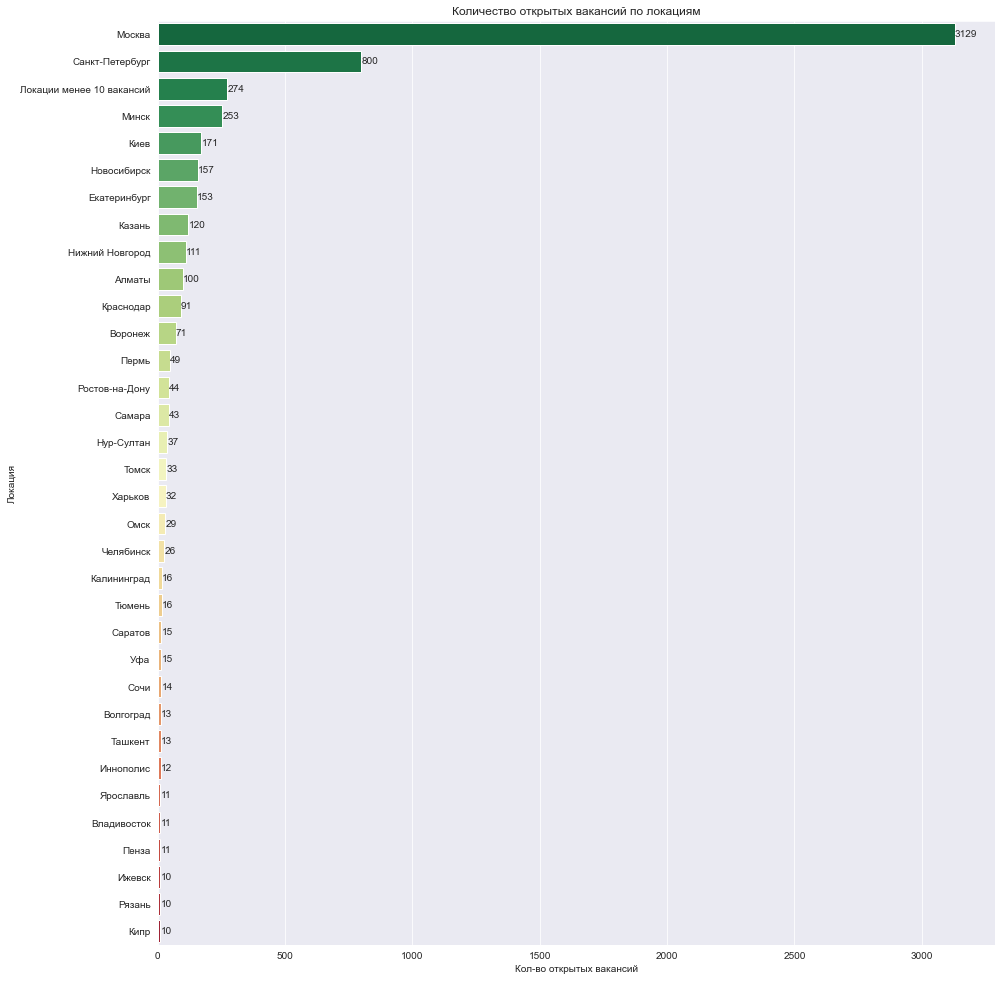

         1 место: Москва (3129)
         2 место: Санкт-Петербург (800)
         3 место: Локации менее 10 вакансий (274)
         4 место: Минск (253)
         5 место: Киев (171)
         6 место: Новосибирск (157)
         7 место: Екатеринбург (153)
         8 место: Казань (120)
         9 место: Нижний Новгород (111)
        10 место: Алматы (100)
        11 место: Краснодар (91)
        12 место: Воронеж (71)
        13 место: Пермь (49)
        14 место: Ростов-на-Дону (44)
        15 место: Самара (43)
        16 место: Нур-Султан (37)
        17 место: Томск (33)
        18 место: Харьков (32)
        19 место: Омск (29)
        20 место: Челябинск (26)
        21 место: Калининград (16)
        22 место: Тюмень (16)
        23 место: Саратов (15)
        24 место: Уфа (15)
        25 место: Сочи (14)
        26 место: Волгоград (13)
        27 место: Ташкент (13)
        28 место: Иннополис (12)
        29 место: Ярославль (11)
        30 место: Владивосток (11)
        31 м

In [49]:
draw_barplot('id', 'area_name', grp, 
             title="Количество открытых вакансий по локациям", 
             xlabel="Кол-во открытых вакансий", 
             ylabel="Локация")

In [50]:
data = data_extended[(data_extended.archived==False) &
                    (data_extended.area_name=="Москва")]
data = data.merge(employers[['employer_id','type', 'site_url', 'industries', 'open_vacancies']], 
                                  on="employer_id", how="left")

## GEODATA VIZUALIZATION

В данных присутствуют географические координаты адресов компаний и ближайших станций метро. Будет интересно посмотреть на различную статистику на карте. Но прежде выясним какая доля данных содержит сведения о координатах.

In [51]:
mapbox_token = load_list('MAPBOX_ACCESS_TOKEN')

In [52]:
data[['address_lat','address_lng','address_metro_lat','address_metro_lng']] = data[['address_lat','address_lng',
                                                                                    'address_metro_lat',
                                                                                    'address_metro_lng']].fillna(999)
print("Доля вакансий с координатами адреса: {:.4f}".format(data[data.address_lat==999]['id'].count()/data.shape[0]))
print("Доля вакансий с координатами метро: {:.4f}".format(data[data.address_metro_lat==999]['id'].count()/data.shape[0]))

grp = data.groupby(["employer_name", "address_lat", "address_lng"])["id"].count().reset_index()
print("Доля компаний с координатами адреса: {:.4f}".format(grp[grp.address_lat==999]['id'].count()/grp.shape[0]))
grp = data.groupby(["employer_name", "address_metro_lat", "address_metro_lng"])["id"].count().reset_index()
print("Доля компаний с координатами метро: {:.4f}".format(grp[grp.address_metro_lat==999]['id'].count()/grp.shape[0]))

Доля вакансий с координатами адреса: 0.5580
Доля вакансий с координатами метро: 0.5928
Доля компаний с координатами адреса: 0.4557
Доля компаний с координатами метро: 0.5305


In [53]:
def draw_geomap_clusters(data, properties, latcol, loncol, zoom):
    points = df_to_geojson(data, 
                       properties=properties,
                       lat=latcol, lon=loncol, precision=3)

    color_stops = create_color_stops([1,10,50,100,200], colors='Greens')

    viz = ClusteredCircleViz(points,
                             access_token=mapbox_token,
                             color_stops=color_stops,
                             radius_stops=[[1,5], [10, 10], [50, 15], [100, 20], [200, 25]],
                             radius_default=2,
                             cluster_maxzoom=10,
                             cluster_radius=30,
                             label_size=12,
                             opacity=0.9,
                             center=(37.6155600, 55.7522200),
                             zoom=zoom)
    viz.show()

Координаты указаны приблизительно для половины вакансий и компаний. Посмотрим на географию расположения этих вакансий и компаний.

In [54]:
tmp = data_extended[(~data_extended.address_lat.isna())][['address_lat','address_lng', 'id', 'employer_name']]
grp = tmp.groupby(['address_lat','address_lng', 'employer_name'])['employer_name'].nunique().rename('emp_cnt').reset_index()
print("География вакансий аналитика данных в мире")
draw_geomap_clusters(grp, properties=['emp_cnt'], latcol='address_lat', loncol='address_lng', zoom=3)

tmp = data[(data.address_metro_lat!=999)][['address_metro_lat','address_metro_lng', 'id']]
print("География открытых вакансий аналитика данных в Москве - метро")
draw_geomap_clusters(tmp, properties=['id'], latcol='address_metro_lat', loncol='address_metro_lng', zoom=9.6)

tmp = data[(data.address_lat!=999)][['address_lat','address_lng', 'id', 'employer_name']]
grp = tmp.groupby(['address_lat','address_lng', 'employer_name'])['employer_name'].nunique().rename('emp_cnt').reset_index()
print("География работодателей с вакансиями аналитика данных в Москве - адреса")
draw_geomap_clusters(grp, properties=['emp_cnt'], latcol='address_lat', loncol='address_lng', zoom=9.6)

География вакансий аналитика данных в мире


География открытых вакансий аналитика данных в Москве - метро


География работодателей с вакансиями аналитика данных в Москве - адреса


## BOOLEAN DATA

In [55]:
bool_cols = list(data.select_dtypes(include='bool').columns)
bool_cols.append("id")

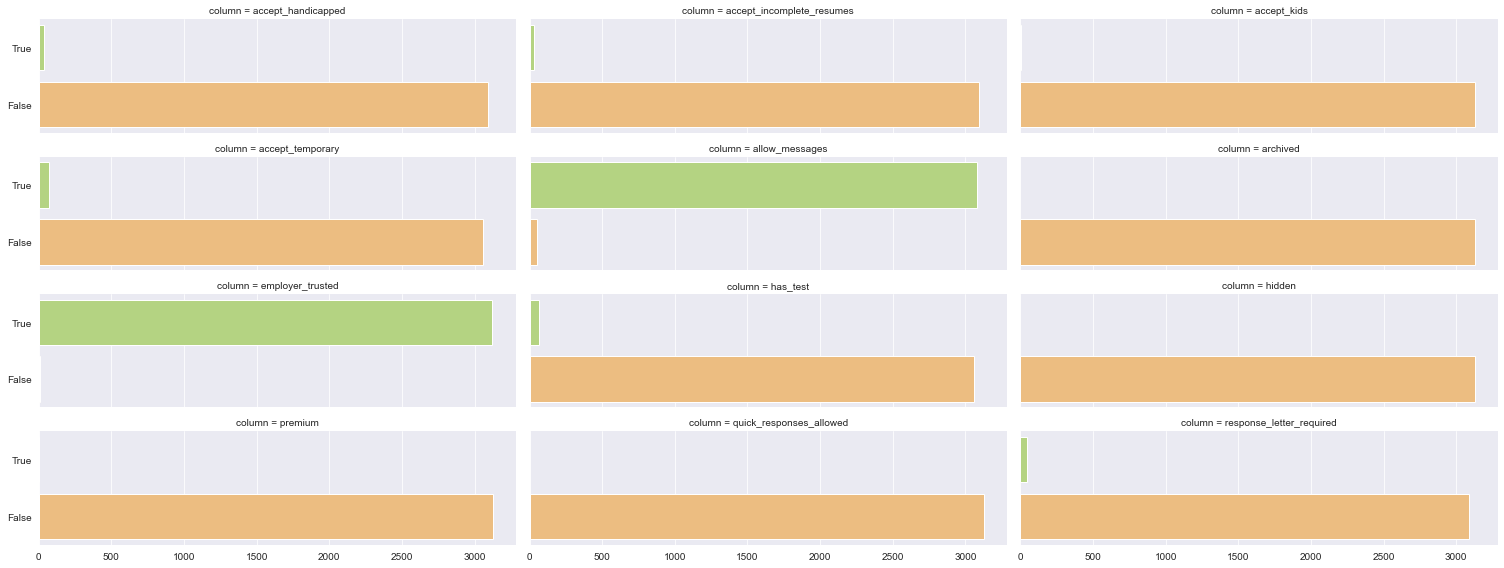

In [56]:
df = data[bool_cols]
df2 = df.melt(id_vars=['id'], var_name='column')
df3 = df2.groupby(['column','value'])['id'].count().reset_index()


g = sns.FacetGrid(data=df3, col='column',col_wrap=3, height=2, aspect=3.5)
plt.ticklabel_format(style='plain', axis='y')
g.map_dataframe(sns.barplot, y='value', x='id', order=[True, False], palette="RdYlGn_r", orient='h')

In [57]:
bool_cols.remove("id")
data.drop(columns=bool_cols, inplace=True)

## EMPLOYER

In [58]:
employers.iloc[3][['employer_id','type', 'site_url', 'industries', 'open_vacancies']]

employer_id                                 7172
type                                     company
site_url                        http://lenta.com
industries        [Розничная сеть (продуктовая)]
open_vacancies                              1833
Name: 3, dtype: object

### TOP-10 по открытым вакансиям

In [59]:
import textwrap

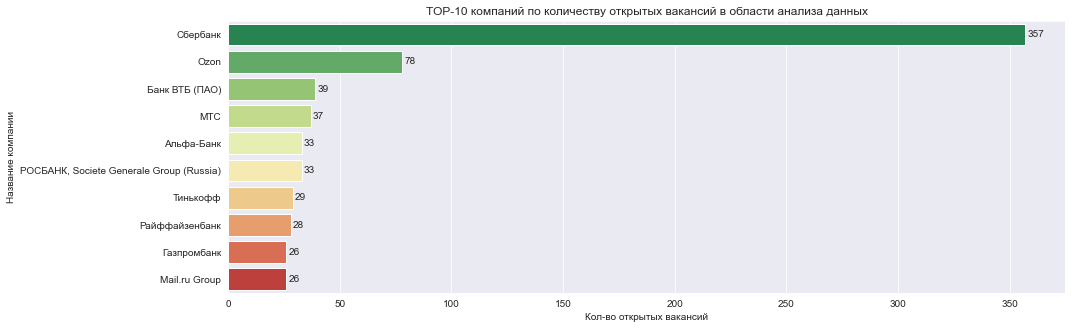

         1 место: Сбербанк (357) [industries: Банк]
         2 место: Ozon (78) [industries: Курьерская, почтовая доставка, Складские услуги, Интернет-магазин, Туристические компании]
         3 место: Банк ВТБ (ПАО) (39) [industries: Управляющая, инвестиционная компания (управление активами), Банк]
         4 место: МТС (37) [industries: Мобильная связь]
         5 место: Альфа-Банк (33) [industries: Банк]
         6 место: РОСБАНК, Societe Generale Group (Russia) (33) [industries: Банк]
         7 место: Тинькофф (29) [industries: Коллекторская деятельность, Банк, Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее), Разработка программного обеспечения, Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг]
         8 место: Райффайзенбанк (28) [industries: Банк]
         9 место: Газпромбанк (26) [industries: Банк]
        10 место: Mail.ru Group (

In [60]:
grp = data[~data.open_vacancies.isna()]
grp['industries'] = grp['industries'].map(tuple)
grp = grp.groupby(['employer_id', 'employer_name','industries']).agg({'id':'count','open_vacancies':'max'}).\
                                        reset_index().sort_values(by="id", ascending=False)[:10]

draw_barplot('id', 'employer_name', grp, 
             title="TOP-10 компаний по количеству открытых вакансий в области анализа данных", 
             xlabel="Кол-во открытых вакансий", 
             ylabel="Название компании", extra_info="industries")

## TOP-20 employer types

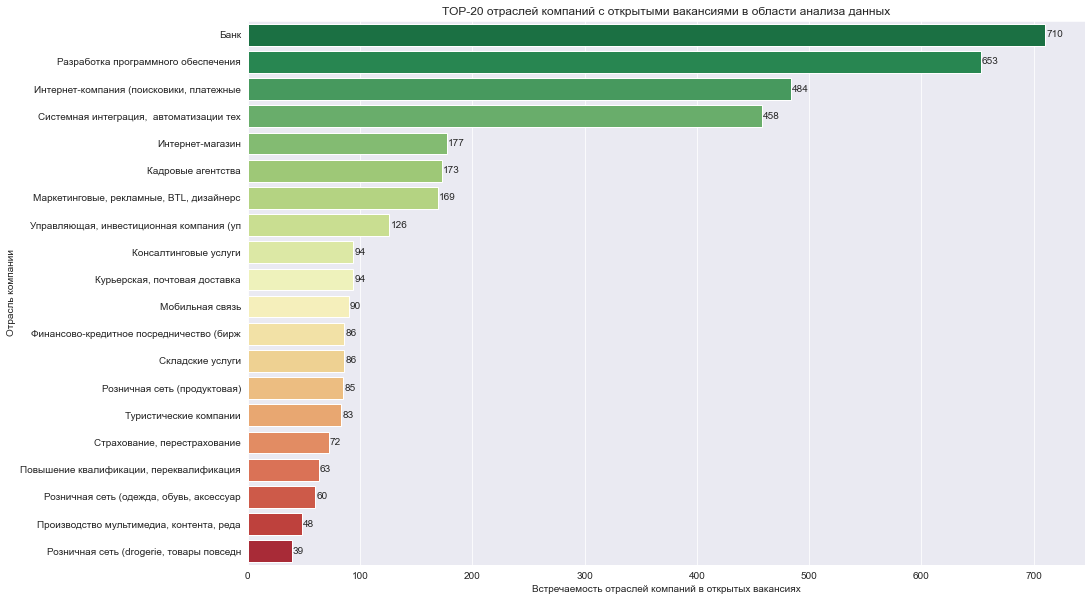

         1 место: Банк (710)
         2 место: Разработка программного обеспечения (653)
         3 место: Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее) (484)
         4 место: Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг (458)
         5 место: Интернет-магазин (177)
         6 место: Кадровые агентства (173)
         7 место: Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок (169)
         8 место: Управляющая, инвестиционная компания (управление активами) (126)
         9 место: Консалтинговые услуги (94)
        10 место: Курьерская, почтовая доставка (94)
        11 место: Мобильная связь (90)
        12 место: Финансово-кредитное посредничество (биржа, брокерская деятельность, выпуск и обслуживание карт, оценка рисков, обменные пункты, агентства по кредитованию, инкассация, ломбард, платежные

In [61]:
all_industries =  data['industries'].explode().dropna()
cnt = Counter(list(all_industries)).most_common(20)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="TOP-20 отраслей компаний с открытыми вакансиями в области анализа данных", 
             xlabel="Встречаемость отраслей компаний в открытых вакансиях", 
             ylabel="Отрасль компании")

## PHRASES SEARCH

In [62]:
data.iloc[0].desc_lemm

'ленточка молодой быстро развивающийся стартап внутри ретейлер лента кратный расти запуститься 100 город любить уметь извлекать польза больший данные ты знак e commerce онлайн сервис приходить мы развиваться развивать новый направление ключевой задача операционный аналитик сделать клиент получать высокий уровень сервис быстрый доставка оптимизировать логистический затрата искать аналитика который нацелить улучшение бизнес показатель компания стремиться помогать команда принимать решение основа данные наш команда предстоять заниматься следующий задача прогнозирование спрос планирование смена исполнитель динамический ценообразование повышение эффективность распределение заказ мультидоставка точно мы иметь опыт розница онлайн проект сервис финтех консалтинг знать математика математический статистика уверенно работать python писать sql запрос иметь опыт построение модель машинный обучение выкатка продакшн автономный самостоятельный способный понять бизнес задача переложить мир данные объяс

In [63]:
your_string = data.iloc[0].desc_lemm
your_search_word = "мы"
list_of_words = your_string.split()
max_index = len(list_of_words)-1
min_index = 0

if list_of_words.index(your_search_word)==min_index:
    prev_word = ""
else:
    prev_word = list_of_words[list_of_words.index(your_search_word) - 1]

if list_of_words.index(your_search_word)==max_index:
    next_word = ""
else:
    next_word = list_of_words[list_of_words.index(your_search_word) + 1]

" ".join([prev_word, your_search_word , next_word])


'приходить мы развиваться'

In [64]:
keyword = 'мы'
before_keyword, keyword, after_keyword = your_string.partition(keyword)
before_keyword

'ленточка молодой быстро развивающийся стартап внутри ретейлер лента кратный расти запуститься 100 город любить уметь извлекать польза больший данные ты знак e commerce онлайн сервис приходить '

In [65]:
# def get_words_around(text, word, words_before='1', words_after='1'):
#     return re.findall('(?:\w+\s){'+words_before+'}'+word+'(?:\s\w+){0,'+words_after+'}', text)
# def get_words_before(text, word,  words_before='1'):
#     return re.findall('(?:\w+\s){'+words_before+'}'+word, text)
# def get_words_after(text, word,  words_after='1'):
#     return re.findall(word+'(?:\s\w+){'+words_after+'}', text)
def get_words_before(all_sentences, word_rus, word_eng, words_before='1'):
    sentences1 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_rus, string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_eng, string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1
def get_words_after(all_sentences, word_rus, word_eng, words_after='1'):
    sentences1 = set([sent for sent in [re.findall(word_rus+'(?:\s\w+){'+words_after+'}', string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall(word_eng+'(?:\s\w+){'+words_after+'}', string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1
def get_words_around(all_sentences, word_rus, word_eng, words_before='1', words_after='1'):
    sentences1 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_rus+'(?:\s\w+){0,'+words_after+'}', 
                                        string) for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_eng+'(?:\s\w+){0,'+words_after+'}',\
                                        string) for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1

def check_frase_in_text(text, search_phrases):
    return any(word in text for word in search_phrases)

In [66]:
all_sentences = [sent for sent in list(data['desc_sentences']) for sent in sent]

## Комфортный офис

In [67]:
get_words_before(all_sentences, "офис", "office", words_before='1')

{'00 офис',
 '16 офис',
 '19 офис',
 '2 офис',
 '20 офис',
 '24 офис',
 '30 офис',
 '300 офис',
 '39 office',
 '4 офис',
 '6 офис',
 '90 office',
 '950 офис',
 'agile офис',
 'back office',
 'benefit office',
 'best office',
 'class office',
 'comfortable office',
 'company office',
 'continent office',
 'cool office',
 'covid офис',
 'cozy office',
 'customer office',
 'data office',
 'employee office',
 'erwin офис',
 'excellent office',
 'front office',
 'gym office',
 'head office',
 'head офис',
 'home office',
 'lille office',
 'location office',
 'lunch office',
 'm office',
 'mango office',
 'marketing office',
 'mc office',
 'microsoft office',
 'middle office',
 'modern office',
 'moscow office',
 'ms office',
 'near office',
 'new office',
 'open office',
 'regional office',
 'remote офис',
 'required office',
 'right office',
 'russia office',
 'sale office',
 'science офис',
 'time офис',
 'u office',
 'visit office',
 'work office',
 'zoom офис',
 'администратор офис',
 '

In [68]:
search_phrases = ['высокотехнологичный офис', 'замечательный офис', 'класс офис', 'классный офис', 'комфорт офис',
                  'комфортабельный офис', 'комфортный офис', 'крутой офис', 'крутый офис', 'отличный офис',
                  'прекрасный офис', 'просторный офис', 'тихий офис', 'удобныe офис', 'удобный офис', 'уютный офис',
                  'функциональный офис', 'хороший офис','benefit office', 'best office', 'class office', 
                  'comfortable office','excellent office',
]

In [69]:
data['is_comf_office'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [70]:
print(f"Количество вакансий с комфортным офисом: {len(data[data['is_comf_office']==True])}")

Количество вакансий с комфортным офисом: 586


In [71]:
data[data['is_comf_office']==True].employer_name.unique()

array(['Uchi.ru', 'Group-IB', 'Тинькофф', 'OPTIPART',
       'Иннотех, Группа компаний', 'Мираторг, Агропромышленный холдинг',
       'SaveTime', 'Криптериум', 'РТИ', 'BestDoctor', 'Alta Personnel',
       'Грин Грей Софтворкс', 'FunCorp', 'ГРЧЦ, ФГУП', 'Wanted', 'РАБЛЗ',
       'Ситимобил', 'ФЛАУВАУ', 'Сбербанк', 'Райффайзенбанк', 'Юнитариус',
       'Техносерв Консалтинг', 'Flocktory',
       'Национальный расчетный депозитарий', 'Lamoda',
       'Медиагруппа «Актион-МЦФЭР»', 'PROFI.RU', 'Group365', 'Nectarin',
       'Газпромбанк', 'Почта Банк', 'BELUGA GROUP',
       'Московский метрополитен', 'Artics Internet Solutions',
       'Брокеркредитсервис', 'ГНИВЦ', 'Villagio Estate',
       'Национальная система платежных карт', 'ЦИФРА', 'Целус Менеджмент',
       'Navicon', 'АИСТ ГЕЙМС', 'S8 Capital', 'Леруа Мерлен',
       'FUSION CORE', 'Manzana Group', 'Skyeng',
       'Российский экспортный центр', 'Yenisei Media', 'Media 108', 'ОТР',
       'Центр экологической безопасности граждан

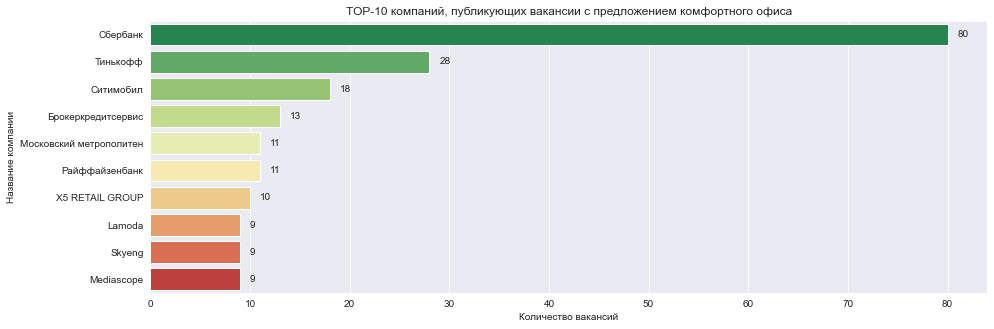

         1 место: Сбербанк (80)
         2 место: Тинькофф (28)
         3 место: Ситимобил (18)
         4 место: Брокеркредитсервис (13)
         5 место: Московский метрополитен (11)
         6 место: Райффайзенбанк (11)
         7 место: X5 RETAIL GROUP (10)
         8 место: Lamoda (9)
         9 место: Skyeng (9)
        10 место: Mediascope (9)


In [72]:
grp = data[data['is_comf_office']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением комфортного офиса", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Удаленная работа

In [73]:
get_words_before(all_sentences, "удалённый", "remote", words_before='1')

{'00 удалённый',
 '100 remote',
 '100 удалённый',
 '19 удалённый',
 '2 удалённый',
 'analyst remote',
 'analyst удалённый',
 'brandquad remote',
 'center remote',
 'collaboratively remote',
 'completely remote',
 'current remote',
 'currently remote',
 'delivery remote',
 'description remote',
 'developer удалённый',
 'dinamo remote',
 'fulltime remote',
 'fulltime удалённый',
 'fully remote',
 'mac удалённый',
 'moscow remote',
 'mostly remote',
 'office remote',
 'option remote',
 'partially remote',
 'skrum удалённый',
 'temporarily remote',
 'time remote',
 'weekly remote',
 'work remote',
 'working remote',
 'yes remote',
 'аналитика удалённый',
 'апрель удалённый',
 'бонус удалённый',
 'вариант удалённый',
 'вильнюс удалённый',
 'возможно удалённый',
 'возможность удалённый',
 'возможный удалённый',
 'время удалённый',
 'выбор удалённый',
 'гибрид удалённый',
 'гибридный удалённый',
 'год удалённый',
 'график remote',
 'график удалённый',
 'графика удалённый',
 'данные удалённый'

In [74]:
any_remote_phrases =  ['00 удалённый', '100 remote', '100 удалённый', '19 удалённый', '2 удалённый', 'analyst remote',
 'analyst удалённый', 'collaboratively remote', 'completely remote', 'current remote', 'currently remote',
 'developer удалённый', 'dinamo remote', 'fulltime remote', 'fulltime удалённый', 'fully remote', 'moscow remote',
 'office remote', 'option remote', 'partially remote', 'temporarily remote', 'time remote', 'weekly remote', 'work remote',
 'working remote', 'yes remote', 'аналитика удалённый', 'апрель удалённый', 'вариант удалённый', 'вильнюс удалённый',
 'возможно удалённый', 'возможность удалённый', 'возможный удалённый', 'время удалённый', 'выбор удалённый',
 'гибридный удалённый', 'год удалённый', 'график remote', 'график удалённый', 'графика удалённый', 'данные удалённый',
 'день удалённый', 'добрынинский удалённый', 'дом удалённый', 'задание удалённый', 'заинтересованный удалённый',
 'занятость удалённый', 'июнь удалённый', 'кандидат удалённый', 'карантин удалённый', 'коворкинг удалённый',
 'команда удалённый', 'комфорт удалённый', 'конец удалённый', 'краснодар удалённый', 'лимасол удалённый', 
 'ломоносов удалённый', 'мгу удалённый', 'место удалённый', 'момент удалённый', 'москва удалённый', 
 'наработаться удалённый', 'неделя удалённый', 'необходимость удалённый', 'обсудить удалённый', 'обсуждать удалённый',
 'обсуждаться удалённый', 'обсуждение удалённый', 'основное удалённый',
 'офис удалённый', 'павелецкий удалённый', 'пандемия удалённый', 'перейти удалённый', 'переслать удалённый',
 'переход удалённый', 'периодический удалённый', 'пермь удалённый', 'пока удалённый', 
 'полностью удалённый', 'полный удалённый', 'поработать удалённый', 'постоянный удалённый', 'практиковать remote',
 'предлагать удалённый', 'предполагать удалённый', 'предполагаться удалённый', 'предусматривать удалённый',
 'преимущественно удалённый', 'профсоюзный удалённый', 'работа удалённый', 'работать удалённый', 'развитие удалённый',
 'рассматривать удалённый', 'режим удалённый', 'результат удалённый', 'савёловский удалённый', 'симферополь удалённый',
 'сити удалённый', 'совмещать удалённый', 'совмещение удалённый', 'ставка удалённый', 'также удалённый',
 'техника удалённый', 'технопарк удалённый', 'третьяковский удалённый', 'удобный удалённый', 'условие удалённый',
 'формат удалённый', 'фрунзенский удалённый', 'частично удалённый', 'частичный удалённый', 
]

In [75]:
data['is_any_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=any_remote_phrases)

Фразы с упоминанием частичной, возможной или временной удалёнки

In [76]:
partially_remote_phrases =  ['collaboratively remote', 'current remote', 'currently remote','option remote', 
'partially remote', 'temporarily remote', 'weekly remote', 'возможно удалённый', 'возможность удалённый', 
'возможный удалённый', 'время удалённый', 'выбор удалённый', 'гибридный удалённый', 'год удалённый', 'данные удалённый',
'день удалённый', 'июнь удалённый', 'карантин удалённый', 'конец удалённый', 'момент удалённый', 'неделя удалённый', 
'обсудить удалённый', 'обсуждать удалённый', 'обсуждаться удалённый', 'обсуждение удалённый', 'основное удалённый',
'перейти удалённый', 'переслать удалённый', 'переход удалённый', 'периодический удалённый',  'пока удалённый', 
'предполагать удалённый', 'предполагаться удалённый', 'предусматривать удалённый',
 'преимущественно удалённый',  'рассматривать удалённый',  'совмещать удалённый', 'совмещение удалённый', 
'частично удалённый', 'частичный удалённый', 
]

In [77]:
data['is_partially_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=partially_remote_phrases)

Фразы с полностью удаленным режимом

In [78]:
fully_remote_phrases =  ['100 remote', '100 удалённый','completely remote', 'fulltime remote', 'fulltime удалённый', 
'fully remote',  'полностью удалённый', 'полный удалённый', 'постоянный удалённый', ]

In [79]:
data['is_fully_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=fully_remote_phrases)

In [80]:
print(f"Количество вакансий с упоминанием удалённой работы: {len(data[data['is_any_remote']==True])}")
print(f"Количество вакансий с упоминанием частичной, возможной или временной удалённой работы: {len(data[data['is_partially_remote']==True])}")
print(f"Количество вакансий с упоминанием полностью удалённой работы: {len(data[data['is_fully_remote']==True])}")

Количество вакансий с упоминанием удалённой работы: 850
Количество вакансий с упоминанием частичной, возможной или временной удалённой работы: 279
Количество вакансий с упоминанием полностью удалённой работы: 86


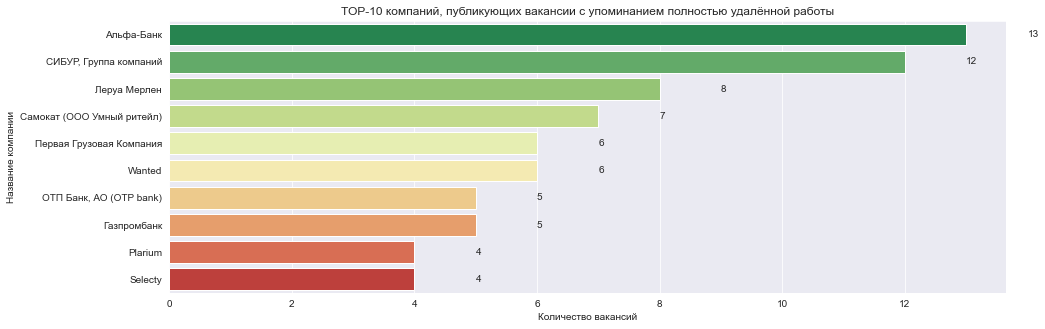

         1 место: Альфа-Банк (13)
         2 место: СИБУР, Группа компаний (12)
         3 место: Леруа Мерлен (8)
         4 место: Самокат (ООО Умный ритейл) (7)
         5 место: Первая Грузовая Компания (6)
         6 место: Wanted (6)
         7 место: ОТП Банк, АО (OTP bank) (5)
         8 место: Газпромбанк (5)
         9 место: Plarium (4)
        10 место: Selecty (4)


In [81]:
grp = data[(data['is_fully_remote']==True) | (data['is_partially_remote']==True)]\
            .groupby(["employer_id", "employer_name"])["employer_id"]\
            .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с упоминанием полностью удалённой работы", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Шаговая доступность от метро

## Оформление по ТК РФ

In [82]:
get_words_before(all_sentences, "тк рф", "labor code", words_before='1')

{'100 тк рф',
 'accordance labor code',
 'according labor code',
 'compliance labor code',
 'comтрудоустройство тк рф',
 'russian labor code',
 'time тк рф',
 'банк тк рф',
 'белый тк рф',
 'гарантия тк рф',
 'день тк рф',
 'компания тк рф',
 'норма тк рф',
 'основа тк рф',
 'отпуск тк рф',
 'официально тк рф',
 'оформлeниe тк рф',
 'оформление тк рф',
 'оформлять тк рф',
 'полностью тк рф',
 'соблюдать тк рф',
 'соблюдение тк рф',
 'согласно тк рф',
 'соответствие тк рф',
 'строго тк рф',
 'требование тк рф',
 'трудоустройство тк рф',
 'уважать тк рф',
 'штат тк рф'}

In [83]:
search_phrases = ["тк рф", "labor code"]

In [84]:
data['is_labor_code'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [85]:
search_len = len(data[data['is_labor_code']==True])
print("Количество вакансий с трудоустройством по ТК РФ: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с трудоустройством по ТК РФ: 994 (31.77%) 


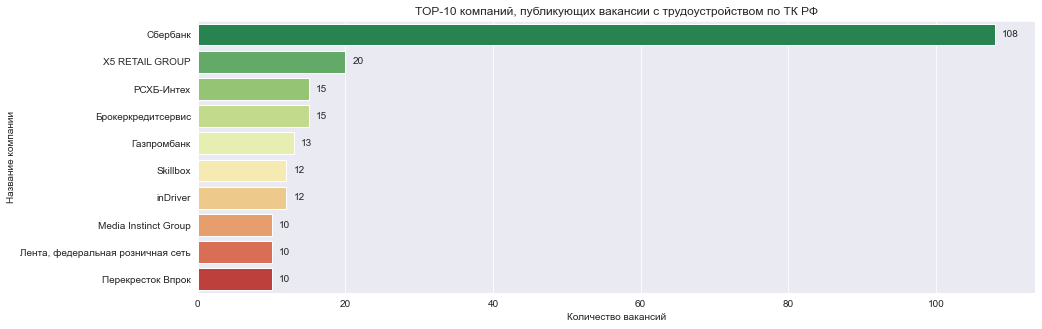

         1 место: Сбербанк (108)
         2 место: X5 RETAIL GROUP (20)
         3 место: РСХБ-Интех (15)
         4 место: Брокеркредитсервис (15)
         5 место: Газпромбанк (13)
         6 место: Skillbox (12)
         7 место: inDriver (12)
         8 место: Media Instinct Group (10)
         9 место: Лента, федеральная розничная сеть (10)
        10 место: Перекресток Впрок (10)


In [86]:
grp = data[data['is_labor_code']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с трудоустройством по ТК РФ", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Белая зарплата

In [87]:
get_words_around(all_sentences, "белый", "white", words_before='1', words_after='1')

{'100 белый заработный',
 '100 белый зп',
 '100 белый оплата',
 'collaborative white',
 'hr белый заработный',
 'occupy white wall',
 'абсолютно белый зарплата',
 'абсолютно белый оформление',
 'банк белый конкурентоспособный',
 'белорусский белый площадь',
 'весь белый своевременно',
 'выплачивать белый зарплата',
 'высокий белый заработный',
 'высокий белый зарплата',
 'гарантировать белый оклад',
 'день белый з',
 'день белый заработный',
 'день белый зарплата',
 'достойный белый заработный',
 'достойный белый зарплата',
 'доход белый выплачивать',
 'естественно белый зарплата',
 'занятость белый зп',
 'зарплата белый стабильно',
 'зарплата белый тк',
 'зп белый',
 'кoнкурентoспoсoбный белый зарабoтный',
 'компания белый заработный',
 'конкурентный белый заработный',
 'конкурентный белый зарплата',
 'конкурентоспособный белый заработный',
 'конкурентоспособный белый зарплата',
 'москва белый площадь',
 'не белый пятно',
 'официальный белый заработный',
 'официальный белый зарплата',

In [88]:
get_words_after(all_sentences, "белый", "white",  words_after='1')

{'white label',
 'white wall',
 'белый белый',
 'белый выплачивать',
 'белый доход',
 'белый дресс',
 'белый з',
 'белый зарабoтный',
 'белый заработать',
 'белый заработный',
 'белый зарплата',
 'белый зп',
 'белый компания',
 'белый конкурентный',
 'белый конкурентоспособный',
 'белый оклад',
 'белый оплата',
 'белый официальный',
 'белый оформление',
 'белый площадь',
 'белый прозрачный',
 'белый пятно',
 'белый своевременно',
 'белый своевременный',
 'белый стабильно',
 'белый тк',
 'белый торговый',
 'белый успешно',
 'белый фиксировать'}

In [89]:
search_phrases = [
 'белый белый',
 'белый выплачивать',
 'белый доход',
 'белый з',
 'белый зарабoтный',
 'белый заработать',
 'белый заработный',
 'белый зарплата',
 'белый зп',
 'белый конкурентный',
 'белый конкурентоспособный',
 'белый оклад',
 'белый оплата',
 'белый официальный',
 'белый оформление',
 'белый прозрачный',
 'белый своевременно',
 'белый своевременный',
 'белый стабильно',
 'белый тк',
 'белый фиксировать']

In [90]:
data['is_white_salary'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [91]:
search_len = len(data[data['is_white_salary']==True])
print("Количество вакансий с белой зарплатой: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с белой зарплатой: 484 (15.47%) 


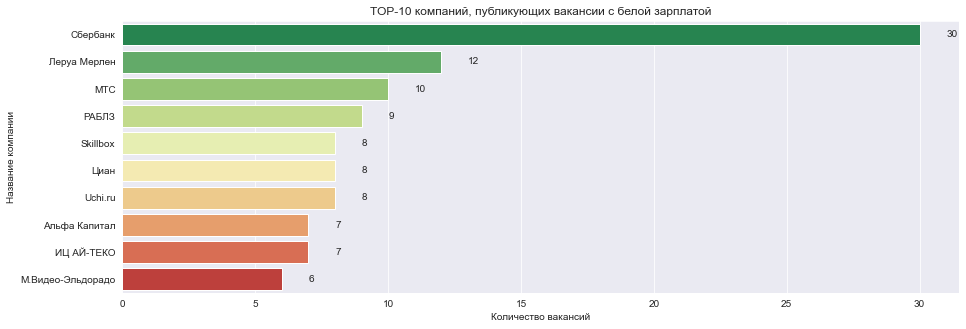

         1 место: Сбербанк (30)
         2 место: Леруа Мерлен (12)
         3 место: МТС (10)
         4 место: РАБЛЗ (9)
         5 место: Skillbox (8)
         6 место: Циан (8)
         7 место: Uchi.ru (8)
         8 место: Альфа Капитал (7)
         9 место: ИЦ АЙ-ТЕКО (7)
        10 место: М.Видео-Эльдорадо (6)


In [92]:
grp = data[data['is_white_salary']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с белой зарплатой", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Шаговая доступность метро

In [218]:
get_words_before(all_sentences, "метро", "subway",  words_before='1')

{'2 метро',
 '32к1 метро',
 'artplay метро',
 'shabolovskaya subway',
 'vorota subway',
 'адрес метро',
 'арма метро',
 'ашан метро',
 'банк метро',
 'бц метро',
 'вечером метро',
 'возле метро',
 'доступность метро',
 'класс метро',
 'кластер метро',
 'комплекс метро',
 'кутузовский метро',
 'лофт метро',
 'лужники метро',
 'метр метро',
 'мина метро',
 'минута метро',
 'москва метро',
 'мцк метро',
 'напротив метро',
 'недалеко метро',
 'около метро',
 'офис метро',
 'пешком метро',
 'проспект метро',
 'прямо метро',
 'работа метро',
 'работодатель метро',
 'развязка метро',
 'район метро',
 'рядом метро',
 'сокол метро',
 'спортивный метро',
 'ст метро',
 'станция метро',
 'столичный метро',
 'транспорт метро',
 'ттк метро',
 'филя метро',
 'ходьба метро',
 'южный метро'}

In [219]:
get_words_before(all_sentences, "ст метро", "станция метро",  words_before='1')

{'4 станция метро',
 '6 станция метро',
 'близкий станция метро',
 'доступность ст метро',
 'доступность станция метро',
 'котёл станция метро',
 'минута станция метро',
 'находиться станция метро',
 'недалеко станция метро',
 'офис станция метро',
 'пешком станция метро',
 'район станция метро',
 'рядом станция метро',
 'транспорт станция метро',
 'х станция метро',
 'ходьба ст метро',
 'ходьба станция метро'}

In [220]:
search_phrases = [
 'возле метро',
 'доступность метро',
 'метр метро',
 'мина метро',
 'минута метро',
 'напротив метро',
 'недалеко метро',
 'около метро',
 'пешком метро',
 'прямо метро',
 'рядом метро',
 'близкий станция метро',
 'доступность ст метро',
 'доступность станция метро',
 'минута станция метро',
 'находиться станция метро',
 'недалеко станция метро',
 'пешком станция метро',
 'рядом станция метро',
 'ходьба ст метро',
 'ходьба станция метро'
 'ходьба метро',
 ]

In [221]:
data['is_near_subway'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [222]:
search_len = len(data[data['is_near_subway']==True])
print("Количество вакансий рядом с метро: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий рядом с метро: 272 (8.69%) 


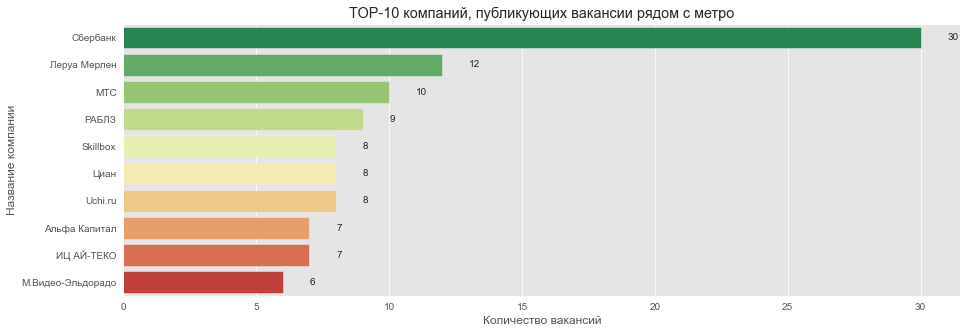

         1 место: Сбербанк (30)
         2 место: Леруа Мерлен (12)
         3 место: МТС (10)
         4 место: РАБЛЗ (9)
         5 место: Skillbox (8)
         6 место: Циан (8)
         7 место: Uchi.ru (8)
         8 место: Альфа Капитал (7)
         9 место: ИЦ АЙ-ТЕКО (7)
        10 место: М.Видео-Эльдорадо (6)


In [223]:
grp = data[data['is_white_salary']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии рядом с метро", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Гибкое начало рабочего дня

In [93]:
get_words_before(all_sentences, "начало рабочий", "start work",  words_before='2')

{'00 гибкий начало рабочий',
 '2 время начало рабочий',
 '2 гибкий начало рабочий',
 '2 плавать начало рабочий',
 'ib фиксировать начало рабочий',
 'package ability start work',
 'schedule flexible start work',
 'time гибкий начало рабочий',
 'возможно гибкий начало рабочий',
 'возможность выбор начало рабочий',
 'возможность гибкий начало рабочий',
 'вознаграждение гибкий начало рабочий',
 'время гибкий начало рабочий',
 'выбор время начало рабочий',
 'выбрать удобный начало рабочий',
 'гибкий время начало рабочий',
 'гибкий график начало рабочий',
 'гибкий подход начало рабочий',
 'график гибкий начало рабочий',
 'график работа начало рабочий',
 'день гибкий начало рабочий',
 'дмс гибкий начало рабочий',
 'дом гибкий начало рабочий',
 'зарплата гибкий начало рабочий',
 'интернет гибкий начало рабочий',
 'код гибкий начало рабочий',
 'коллега плавать начало рабочий',
 'корректировать время начало рабочий',
 'не смотреть начало рабочий',
 'неделя гибкий начало рабочий',
 'отпуск гибкий

In [94]:
get_words_before(all_sentences, "начало работа", "begin work",  words_before='2')


{'2 время начало работа',
 'group упрощать начало работа',
 'выбрать время начало работа',
 'выбрать режим начало работа',
 'гибкий время начало работа',
 'гибкий график начало работа',
 'гибкий утро начало работа',
 'месяц дата начало работа',
 'помощь бизнес начало работа',
 'стандарт полгода начало работа'}

In [95]:
get_words_before(all_sentences, "работа начало", "work begin",  words_before='2')

{'гибкий график работа начало', 'собственный график работа начало'}

In [96]:
search_phrases = ['гибкий начало рабочий',
 'плавать начало рабочий',
 'выбор начало рабочий',
'выбор время начало рабочий',
 'удобный начало рабочий',
 'гибкий график начало рабочий',
 'гибкий подход начало рабочий',
 'график гибкий начало рабочий',
 'корректировать время начало рабочий',
 'не смотреть начало рабочий',
 'удобный время начало рабочий',
  'выбрать время начало работа',
 'выбрать режим начало работа',
 'гибкий время начало работа',
 'гибкий график начало работа',
 'гибкий утро начало работа', 
'гибкий график работа начало', 
'собственный график работа начало',
                   'flexible start work',
                 
                 ]

In [97]:
data['is_flexible_daystart'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [98]:
search_len = len(data[data['is_flexible_daystart']==True])
print("Количество вакансий с гибким началом рабочего дня: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с гибким началом рабочего дня: 224 (7.16%) 


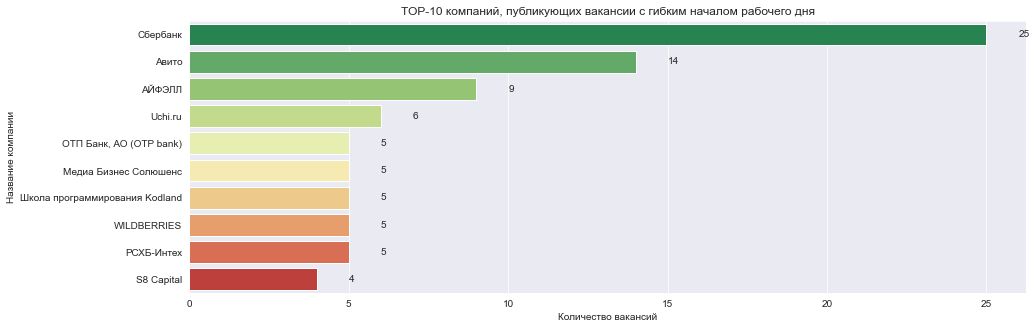

         1 место: Сбербанк (25)
         2 место: Авито (14)
         3 место: АЙФЭЛЛ (9)
         4 место: Uchi.ru (6)
         5 место: ОТП Банк, АО (OTP bank) (5)
         6 место: Медиа Бизнес Солюшенс (5)
         7 место: Школа программирования Kodland (5)
         8 место: WILDBERRIES (5)
         9 место: РСХБ-Интех (5)
        10 место: S8 Capital (4)


In [99]:
grp = data[data['is_flexible_daystart']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с гибким началом рабочего дня", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Карьерный рост

In [100]:
get_words_before(all_sentences, "карьера", "career",  words_before='1')

{'alignment career',
 'build career',
 'chance career',
 'check career',
 'compensation career',
 'corporate career',
 'desired career',
 'development career',
 'exactly career',
 'exciting career',
 'future career',
 'growth career',
 'job career',
 'opportunity career',
 'professional career',
 'ru career',
 'skill career',
 'thinking career',
 'top career',
 'vertical career',
 'visit career',
 'ваш карьера',
 'возможность карьера',
 'выбрать карьера',
 'идеальный карьера',
 'начало карьера',
 'начать карьера',
 'планирование карьера',
 'построение карьера',
 'построить карьера',
 'продолжить карьера',
 'профессиональный карьера',
 'развивать карьера',
 'развитие карьера',
 'сделать карьера',
 'собственный карьера',
 'старт карьера',
 'успешный карьера',
 'хабра карьера',
 'этап карьера'}

In [101]:
get_words_before(all_sentences, "карьерный", "career",  words_before='1')


{'14возможность карьерный',
 'alignment career',
 'build career',
 'chance career',
 'check career',
 'compensation career',
 'corporate career',
 'desired career',
 'development career',
 'exactly career',
 'exciting career',
 'founder карьерный',
 'future career',
 'growth career',
 'job career',
 'opportunity career',
 'professional career',
 'ru career',
 'skill career',
 'thinking career',
 'top career',
 'vertical career',
 'visit career',
 'быстрый карьерный',
 'вероятность карьерный',
 'возможность карьерный',
 'вопрос карьерный',
 'выбирать карьерный',
 'вырасти карьерный',
 'вытекать карьерный',
 'двигаться карьерный',
 'задача карьерный',
 'квалификация карьерный',
 'крутой карьерный',
 'личностный карьерный',
 'материальный карьерный',
 'мероприятие карьерный',
 'наш карьерный',
 'невероятный карьерный',
 'неограниченный карьерный',
 'непрерывный карьерный',
 'нужно карьерный',
 'отклик карьерный',
 'перспектива карьерный',
 'помогать карьерный',
 'понятный карьерный',
 'пр

In [102]:
search_phrases = [
 'build career',
 'chance career',
 'growth career',
 'opportunity career',
 'vertical career',
 'возможность карьера',
 'планирование карьера',
 'построение карьера',
 'построить карьера',
 'продолжить карьера',
 'профессиональный карьера',
 'развивать карьера',
 'развитие карьера',
 'сделать карьера',
 'собственный карьера',
 'быстрый карьерный',
 'вероятность карьерный',
 'возможность карьерный',
 'вырасти карьерный',
 'вытекать карьерный',
 'двигаться карьерный',
 'крутой карьерный',
 'личностный карьерный',
 'невероятный карьерный',
 'неограниченный карьерный',
 'непрерывный карьерный',
 'перспектива карьерный',
 'помогать карьерный',
 'понятный карьерный',
 'предполагать карьерный',
 'продвижение карьерный',
 'профессионально карьерный',
 'профессиональный карьерный',
 'развитие карьерный',
 'расти карьерный',
 'рост карьерный',
 'саморазвитие карьерный',
                 ]

In [103]:
data['is_career_growth'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [104]:
search_len = len(data[data['is_career_growth']==True])
print("Количество вакансий с предложением карьерного роста: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с предложением карьерного роста: 464 (14.83%) 


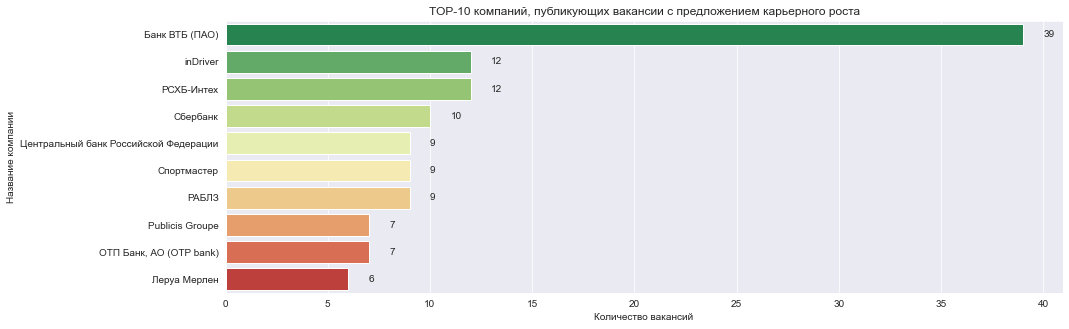

         1 место: Банк ВТБ (ПАО) (39)
         2 место: inDriver (12)
         3 место: РСХБ-Интех (12)
         4 место: Сбербанк (10)
         5 место: Центральный банк Российской Федерации (9)
         6 место: Спортмастер (9)
         7 место: РАБЛЗ (9)
         8 место: Publicis Groupe (7)
         9 место: ОТП Банк, АО (OTP bank) (7)
        10 место: Леруа Мерлен (6)


In [105]:
grp = data[data['is_career_growth']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением карьерного роста", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## Бесплатные бонусы

In [209]:
get_words_after(all_sentences, "счёт компания", "счёт работодатель",  words_after='3')

{'счёт компания 80 час тренинг',
 'счёт компания coursera new prolab',
 'счёт компания new prolab bigdata',
 'счёт компания безлимитный снький бар',
 'счёт компания внешний тренинг семинар',
 'счёт компания внутренний внешний курс',
 'счёт компания внутренний внешний обучение',
 'счёт компания выплата материальный помощь',
 'счёт компания готовить публичный выступление',
 'счёт компания дмс корпоративный скидка',
 'счёт компания завершение испытательный срок',
 'счёт компания изучать английский язык',
 'счёт компания интересный сложный амбициозный',
 'счёт компания компенсация мобильный связь',
 'счёт компания конференция внешний курс',
 'счёт компания корпоративный библиотека alpina',
 'счёт компания льготный условие кредитование',
 'счёт компания мочь пообедать выпить',
 'счёт компания онлайн школа английский',
 'счёт компания оплата дмс новый',
 'счёт компания оплачивать участие российский',
 'счёт компания очный мастер класс',
 'счёт компания посещать конференция профессиональный',

In [106]:
get_words_after(all_sentences, "бесплатно", "free",  words_after='2')

{'free breakfast lunch',
 'free drink fruit',
 'free english course',
 'free english lesson',
 'free live work',
 'free live yoga',
 'free loyal working',
 'free lunch fruit',
 'free online exercise',
 'free parking area',
 'free play mmo',
 'free play проект',
 'free rl алгоритм',
 'free salary comprehensive',
 'free streaming television',
 'free submit cv',
 'free time higher',
 'free top ps',
 'free гибкий рабочий',
 'бесплатно вместительный подземный',
 'бесплатно набирать команда',
 'бесплатно независимо размер',
 'бесплатно проходить обучение',
 'бесплатно сертификат spark',
 'бесплатно фрукт офис'}

In [107]:
get_words_after(all_sentences, "бесплатный", "free",  words_after='2')

{'free breakfast lunch',
 'free drink fruit',
 'free english course',
 'free english lesson',
 'free live work',
 'free live yoga',
 'free loyal working',
 'free lunch fruit',
 'free online exercise',
 'free parking area',
 'free play mmo',
 'free play проект',
 'free rl алгоритм',
 'free salary comprehensive',
 'free streaming television',
 'free submit cv',
 'free time higher',
 'free top ps',
 'free гибкий рабочий',
 'бесплатный авто вести',
 'бесплатный автобус ст',
 'бесплатный английский фитнес',
 'бесплатный английский фитнесса',
 'бесплатный билет концерт',
 'бесплатный билет спонсировать',
 'бесплатный больший автомобильный',
 'бесплатный вкусный обед',
 'бесплатный вкусный питание',
 'бесплатный диагностик лечение',
 'бесплатный доставка день',
 'бесплатный доступ корпоративный',
 'бесплатный доступ курс',
 'бесплатный доступ любой',
 'бесплатный доступ электронный',
 'бесплатный ежегодный диспансеризация',
 'бесплатный завтрак вкусный',
 'бесплатный завтрак обед',
 'бесплатн

In [212]:
get_words_before(all_sentences, "счёт компания", "счёт работодатель",  words_before='2')

{'анализ данные счёт компания',
 'билет кипр счёт компания',
 'внешний обучение счёт компания',
 'внутренний обучение счёт компания',
 'возможность обучаться счёт компания',
 'возможность обучение счёт компания',
 'возможность обучение счёт работодатель',
 'возможность получить счёт компания',
 'дмс обучение счёт компания',
 'дополнительный benefits счёт компания',
 'ежегодный обучение счёт компания',
 'квалификация обучаться счёт компания',
 'класс литература счёт компания',
 'компания полностью счёт работодатель',
 'конференция курс счёт компания',
 'конференция митапа счёт компания',
 'конференция обучение счёт компания',
 'конференция тренинг счёт компания',
 'корпоративный обучение счёт компания',
 'курс программа счёт компания',
 'курс сертификация счёт компания',
 'любой железо счёт компания',
 'митапа обучение счёт компания',
 'оборудование обед счёт компания',
 'обучаться сертифицироваться счёт компания',
 'обучение конференция счёт компания',
 'обучение развитие счёт компания

In [213]:
search_phrases_food = [
 'free breakfast lunch',
 'free lunch fruit',
 'бесплатный вкусный',
 'бесплатный завтрак',
 'бесплатный здоровый еда',
 'бесплатный корпоративный кафе',
 'бесплатный кухня перекус',
 'бесплатный обед',
 'бесплатный питание',
 'бесплатный чай',
 'бесплатный плюшка печение',
 'бесплатный столовая',
 'бесплатный спортзал столовая',
 'бесплатно фрукт офис',
 'счёт компания безлимитный снький бар',
    'счёт компания мочь пообедать выпить',
 'печенька конфета счёт компания',
 'пицца пиво счёт компания',
 'оборудование обед счёт компания',
]

search_phrases_drink = [
 'пицца пиво счёт компания',
 'free drink fruit',
 'бесплатный кофе',
 'бесплатный пиво',
 'счёт компания безлимитный снький бар',
    'счёт компания мочь пообедать выпить',
 'работать бар счёт компания',
]
search_phrases_learning = [
 'free english',
 'бесплатный английский',
 'бесплатный занятие английский',
 'free online exercise',
 'бесплатный доступ курс',
 'бесплатный доступ электронный',
 'бесплатный корпоративный',
 'бесплатный курс английский',
 'бесплатный обучение',
 'бесплатный электронный библиотека',
 'бесплатно проходить обучение',
 'бесплатно сертификат spark',
    'счёт компания внешний тренинг семинар',
 'счёт компания внутренний внешний курс',
 'счёт компания внутренний внешний обучение',
    'счёт компания изучать английский язык',
    'счёт компания конференция внешний курс',
 'счёт компания корпоративный библиотека alpina',
    'счёт компания онлайн школа английский',
    'внешний обучение счёт компания',
 'внутренний обучение счёт компания',
 'возможность обучаться счёт компания',
 'возможность обучение счёт компания',
 'возможность обучение счёт работодатель','дмс обучение счёт компания',
 'ежегодный обучение счёт компания',
 'квалификация обучаться счёт компания',
 'класс литература счёт компания',
 'компания полностью счёт работодатель',
 'конференция курс счёт компания',
 'конференция митапа счёт компания',
 'конференция обучение счёт компания',
 'конференция тренинг счёт компания',
 'корпоративный обучение счёт компания',
 'курс программа счёт компания',
 'курс сертификация счёт компания',
 'митапа обучение счёт компания',
 'обучаться сертифицироваться счёт компания',
 'обучение конференция счёт компания',
 'обучение развитие счёт компания',
 'обучение сертификация счёт компания',
 'платформа обучение счёт компания',
 'повышать квалификация счёт компания',
 'повышать квалификация счёт работодатель',
 'повышение квалификация счёт компания',
 'повышение квалификация счёт работодатель',
 'покупка книга счёт компания',
 'профессиональный курс счёт компания',
 'профессиональный обучение счёт компания',
 'профильный курс счёт компания',
 'профильный обучение счёт компания',
 'проходить обучение счёт компания',
 'прохождение сертификация счёт компания',
 'развитие обучение счёт компания',
 'рост обучение счёт компания',
 'семинар курс счёт компания',
 'сотрудник образование счёт компания',
 'также обучение счёт компания',
 'топ обучение счёт компания',
 'университет сбер счёт компания',
]
search_phrases_gym = [
 'бесплатный английский фитнесса',
 'бесплатный английский фитнес', 
'free live yoga',
 'бесплатный занятие йога',
 'бесплатный настольный теннис',
 'бесплатный фитнес',
 'бесплатный корпоративный футбол',
 'бесплатный оздоровительный спортивный',
 'бесплатный посещение тренажёрный',
 'бесплатный спорт собственный',
 'бесплатный спортзал',
 'бесплатный спортивный танцевальный',
 'бесплатный тренажёрный зал',
 'бесплатный пользование спортивный',
 'бесплатный посещение бассейн',
 'бесплатный занятие спорт',
 'бесплатный площадка футбол',
]
search_phrases_parking = [   
 'free parking area',
 'бесплатный больший автомобильный',
 'бесплатный охранять парковка',
 'бесплатный парковка',
 'бесплатный подземный',
 'бесплатный фитнес парковка',
 'бесплатный фитнес подземный',
    'бесплатно вместительный подземный',
]
search_phrases_transport = [   
    
 'бесплатный авто вести',
 'бесплатный автобус ст',
 'бесплатный корпоративный транспорт',
 'бесплатный проезд железный',
 'бесплатный проезд столичный',
]
search_phrases_dms = [   
     
 'бесплатный диагностик лечение',
 'бесплатный ежегодный диспансеризация',
 'бесплатный консультация врач',
 'бесплатный медицинский страховка',
 'бесплатный медицинский услуга',
    'счёт компания оплата дмс новый',
    
 'стоматология частично счёт компания',
                 ]
    
search_phrases_mobile = [    
 'бесплатный мобильный связь',
    'счёт компания компенсация мобильный связь',
]

In [214]:
data['is_free_food'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_food)
data['is_free_drink'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_drink)
data['is_free_learning'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_learning)
data['is_free_gym'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_gym)
data['is_free_parking'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_parking)
data['is_free_transport'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_transport)
data['is_free_dms'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_dms)
data['is_free_mobile'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_mobile)

In [215]:
print("Количество вакансий с предложением бесплатной еды: {} ({:.2f}%)".format(len(data[data['is_free_food']==True]),
                                              len(data[data['is_free_food']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатных напитков: {} ({:.2f}%)".format(len(data[data['is_free_drink']==True]),
                                              len(data[data['is_free_drink']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного обучения: {} ({:.2f}%)".format(len(data[data['is_free_learning']==True]),
                                              len(data[data['is_free_learning']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного фитнеса: {} ({:.2f}%)".format(len(data[data['is_free_gym']==True]),
                                              len(data[data['is_free_gym']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатной парковки: {} ({:.2f}%)".format(len(data[data['is_free_parking']==True]),
                                              len(data[data['is_free_parking']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного проезда: {} ({:.2f}%)".format(len(data[data['is_free_transport']==True]),
                                              len(data[data['is_free_transport']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатных медуслуг: {} ({:.2f}%)".format(len(data[data['is_free_dms']==True]),
                                              len(data[data['is_free_dms']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатной мобильной связи: {} ({:.2f}%)".format(len(data[data['is_free_mobile']==True]),
                                              len(data[data['is_free_mobile']==True])/len(data)*100))

Количество вакансий с предложением бесплатной еды: 112 (3.58%)
Количество вакансий с предложением бесплатных напитков: 28 (0.89%)
Количество вакансий с предложением бесплатного обучения: 314 (10.04%)
Количество вакансий с предложением бесплатного фитнеса: 170 (5.43%)
Количество вакансий с предложением бесплатной парковки: 101 (3.23%)
Количество вакансий с предложением бесплатного проезда: 21 (0.67%)
Количество вакансий с предложением бесплатных медуслуг: 9 (0.29%)
Количество вакансий с предложением бесплатной мобильной связи: 6 (0.19%)


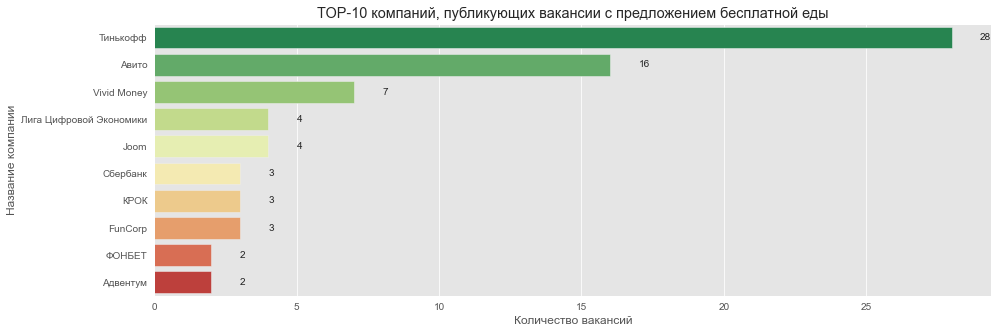

         1 место: Тинькофф (28)
         2 место: Авито (16)
         3 место: Vivid Money (7)
         4 место: Лига Цифровой Экономики (4)
         5 место: Joom (4)
         6 место: Сбербанк (3)
         7 место: КРОК (3)
         8 место: FunCorp (3)
         9 место: ФОНБЕТ (2)
        10 место: Адвентум (2)


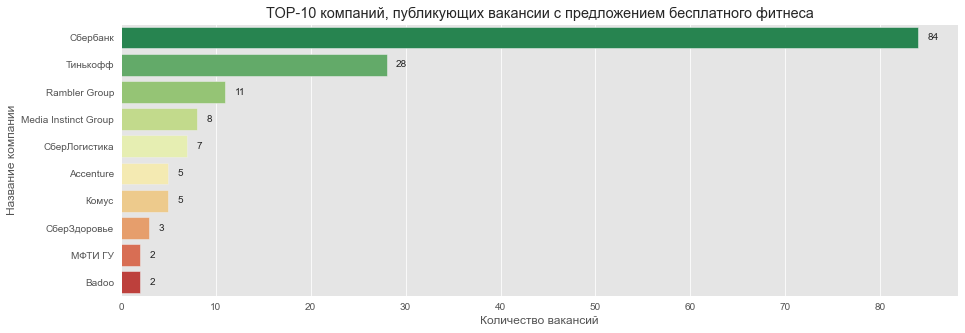

         1 место: Сбербанк (84)
         2 место: Тинькофф (28)
         3 место: Rambler Group (11)
         4 место: Media Instinct Group (8)
         5 место: СберЛогистика (7)
         6 место: Accenture (5)
         7 место: Комус (5)
         8 место: СберЗдоровье (3)
         9 место: МФТИ ГУ (2)
        10 место: Badoo (2)


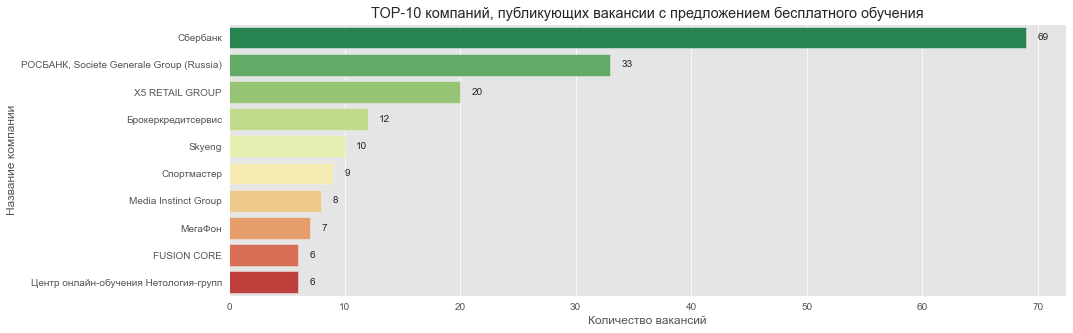

         1 место: Сбербанк (69)
         2 место: РОСБАНК, Societe Generale Group (Russia) (33)
         3 место: X5 RETAIL GROUP (20)
         4 место: Брокеркредитсервис (12)
         5 место: Skyeng (10)
         6 место: Спортмастер (9)
         7 место: Media Instinct Group (8)
         8 место: МегаФон (7)
         9 место: FUSION CORE (6)
        10 место: Центр онлайн-обучения Нетология-групп (6)


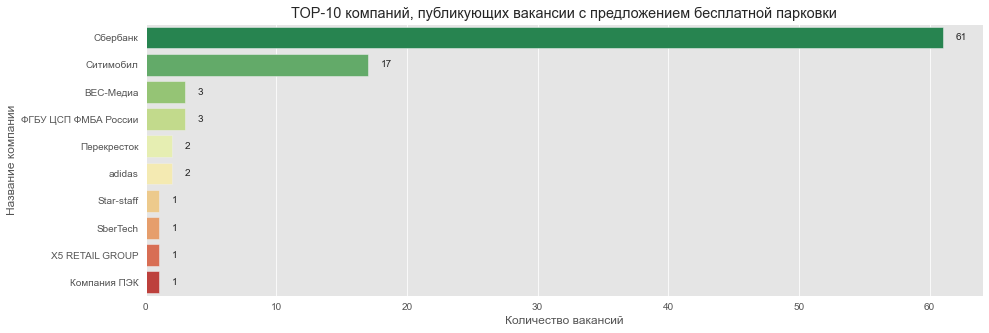

         1 место: Сбербанк (61)
         2 место: Ситимобил (17)
         3 место: ВЕС-Медиа (3)
         4 место: ФГБУ ЦСП ФМБА России (3)
         5 место: Перекресток (2)
         6 место: adidas (2)
         7 место: Star-staff (1)
         8 место: SberTech (1)
         9 место: X5 RETAIL GROUP (1)
        10 место: Компания ПЭК (1)


In [216]:
grp = data[data['is_free_food']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением бесплатной еды", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

grp = data[data['is_free_gym']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением бесплатного фитнеса", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

grp = data[data['is_free_learning']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением бесплатного обучения", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")


grp = data[data['is_free_parking']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии с предложением бесплатной парковки", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

## TOP KEY SKILLS

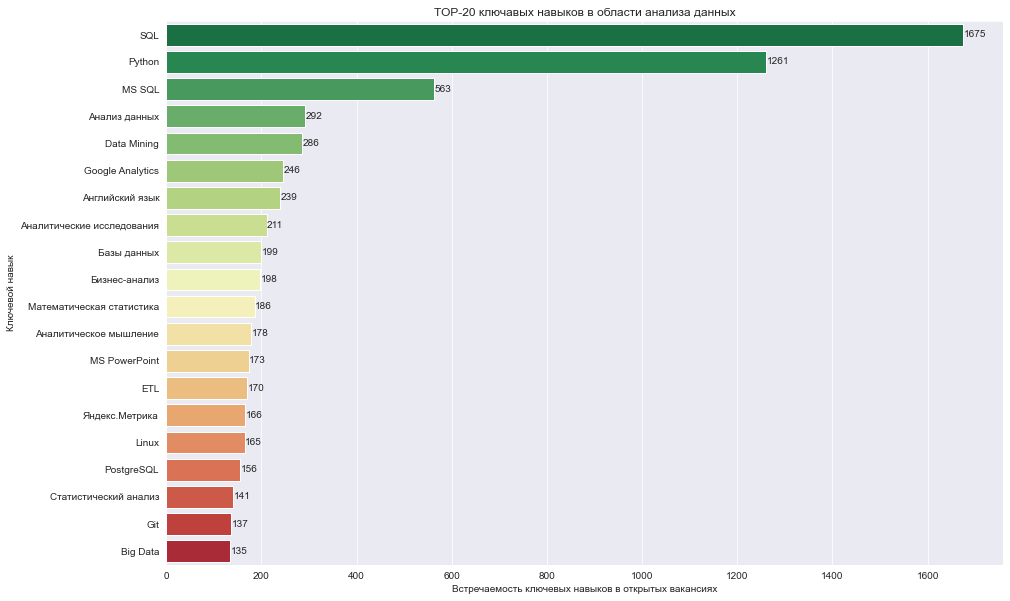

         1 место: SQL (1675)
         2 место: Python (1261)
         3 место: MS SQL (563)
         4 место: Анализ данных (292)
         5 место: Data Mining (286)
         6 место: Google Analytics (246)
         7 место: Английский язык (239)
         8 место: Аналитические исследования (211)
         9 место: Базы данных (199)
        10 место: Бизнес-анализ (198)
        11 место: Математическая статистика (186)
        12 место: Аналитическое мышление (178)
        13 место: MS PowerPoint (173)
        14 место: ETL (170)
        15 место: Яндекс.Метрика (166)
        16 место: Linux (165)
        17 место: PostgreSQL (156)
        18 место: Статистический анализ (141)
        19 место: Git (137)
        20 место: Big Data (135)


In [112]:
all_key_skills = [skill for skill in list(data['key_skills']) for skill in skill]
cnt = Counter(list(all_key_skills)).most_common(20)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="TOP-20 ключавых навыков в области анализа данных", 
             xlabel="Встречаемость ключевых навыков в открытых вакансиях", 
             ylabel="Ключевой навык")

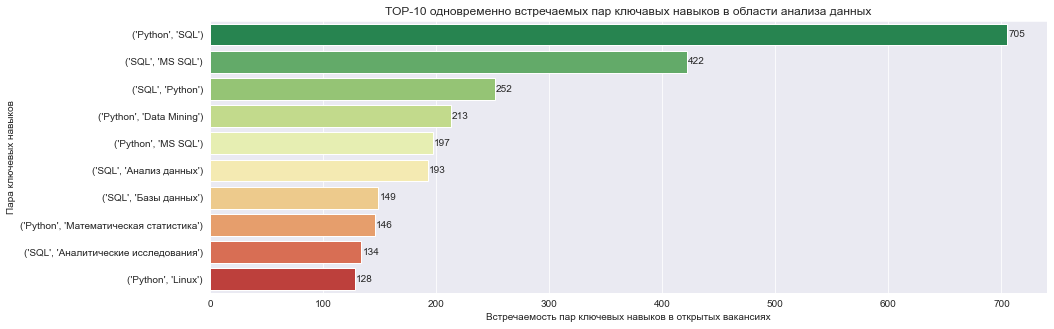

         1 место: ('Python', 'SQL') (705)
         2 место: ('SQL', 'MS SQL') (422)
         3 место: ('SQL', 'Python') (252)
         4 место: ('Python', 'Data Mining') (213)
         5 место: ('Python', 'MS SQL') (197)
         6 место: ('SQL', 'Анализ данных') (193)
         7 место: ('SQL', 'Базы данных') (149)
         8 место: ('Python', 'Математическая статистика') (146)
         9 место: ('SQL', 'Аналитические исследования') (134)
        10 место: ('Python', 'Linux') (128)


In [113]:
tmp = occurences_counter(data.key_skills, num=2)
cnt_data = pd.DataFrame(tmp.most_common(10))
draw_barplot(1, 0, cnt_data, 
             title="TOP-10 одновременно встречаемых пар ключавых навыков в области анализа данных", 
             xlabel="Встречаемость пар ключевых навыков в открытых вакансиях", 
             ylabel="Пара ключевых навыков")

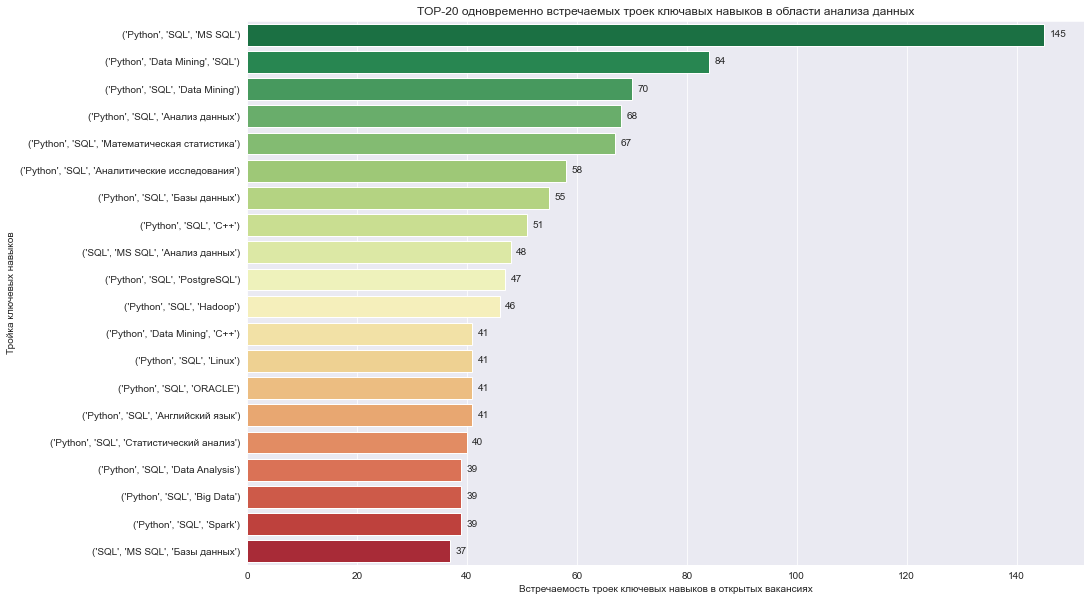

         1 место: ('Python', 'SQL', 'MS SQL') (145)
         2 место: ('Python', 'Data Mining', 'SQL') (84)
         3 место: ('Python', 'SQL', 'Data Mining') (70)
         4 место: ('Python', 'SQL', 'Анализ данных') (68)
         5 место: ('Python', 'SQL', 'Математическая статистика') (67)
         6 место: ('Python', 'SQL', 'Аналитические исследования') (58)
         7 место: ('Python', 'SQL', 'Базы данных') (55)
         8 место: ('Python', 'SQL', 'C++') (51)
         9 место: ('SQL', 'MS SQL', 'Анализ данных') (48)
        10 место: ('Python', 'SQL', 'PostgreSQL') (47)
        11 место: ('Python', 'SQL', 'Hadoop') (46)
        12 место: ('Python', 'Data Mining', 'C++') (41)
        13 место: ('Python', 'SQL', 'Linux') (41)
        14 место: ('Python', 'SQL', 'ORACLE') (41)
        15 место: ('Python', 'SQL', 'Английский язык') (41)
        16 место: ('Python', 'SQL', 'Статистический анализ') (40)
        17 место: ('Python', 'SQL', 'Data Analysis') (39)
        18 место: ('Python',

In [114]:
tmp = occurences_counter(data.key_skills, num=3)
cnt_data = pd.DataFrame(tmp.most_common(20))
draw_barplot(1, 0, cnt_data, 
             title="TOP-20 одновременно встречаемых троек ключавых навыков в области анализа данных", 
             xlabel="Встречаемость троек ключевых навыков в открытых вакансиях", 
             ylabel="Тройка ключевых навыков")

## TOP KEY PHRASES

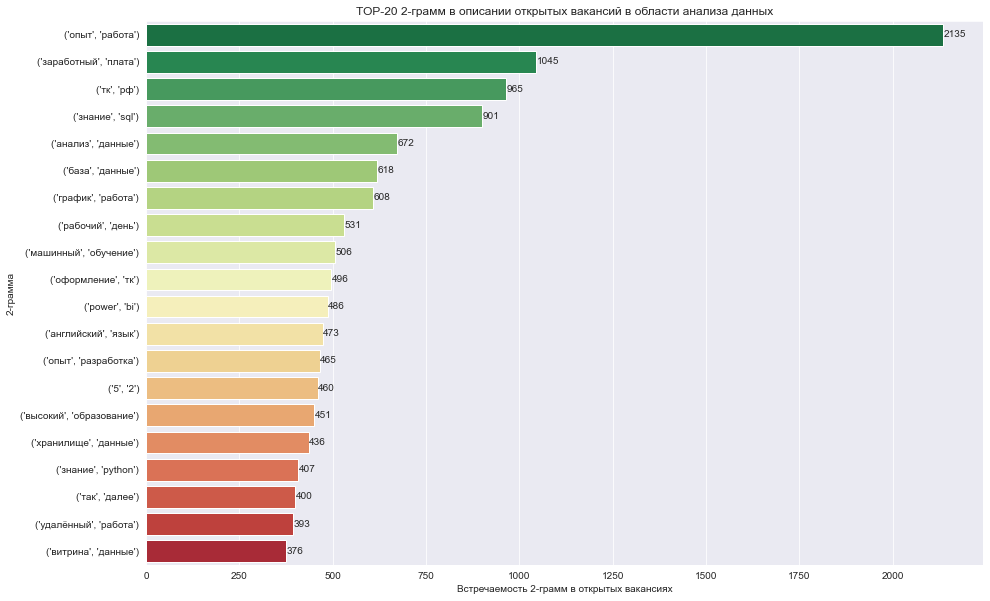

         1 место: ('опыт', 'работа') (2135)
         2 место: ('заработный', 'плата') (1045)
         3 место: ('тк', 'рф') (965)
         4 место: ('знание', 'sql') (901)
         5 место: ('анализ', 'данные') (672)
         6 место: ('база', 'данные') (618)
         7 место: ('график', 'работа') (608)
         8 место: ('рабочий', 'день') (531)
         9 место: ('машинный', 'обучение') (506)
        10 место: ('оформление', 'тк') (496)
        11 место: ('power', 'bi') (486)
        12 место: ('английский', 'язык') (473)
        13 место: ('опыт', 'разработка') (465)
        14 место: ('5', '2') (460)
        15 место: ('высокий', 'образование') (451)
        16 место: ('хранилище', 'данные') (436)
        17 место: ('знание', 'python') (407)
        18 место: ('так', 'далее') (400)
        19 место: ('удалённый', 'работа') (393)
        20 место: ('витрина', 'данные') (376)


In [115]:
tmp = Counter([ngram for ngram in data['good_key_phrases_2grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common(20))
draw_barplot(1, 0, cnt_data, 
             title="TOP-20 2-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 2-грамм в открытых вакансиях", 
             ylabel="2-грамма")

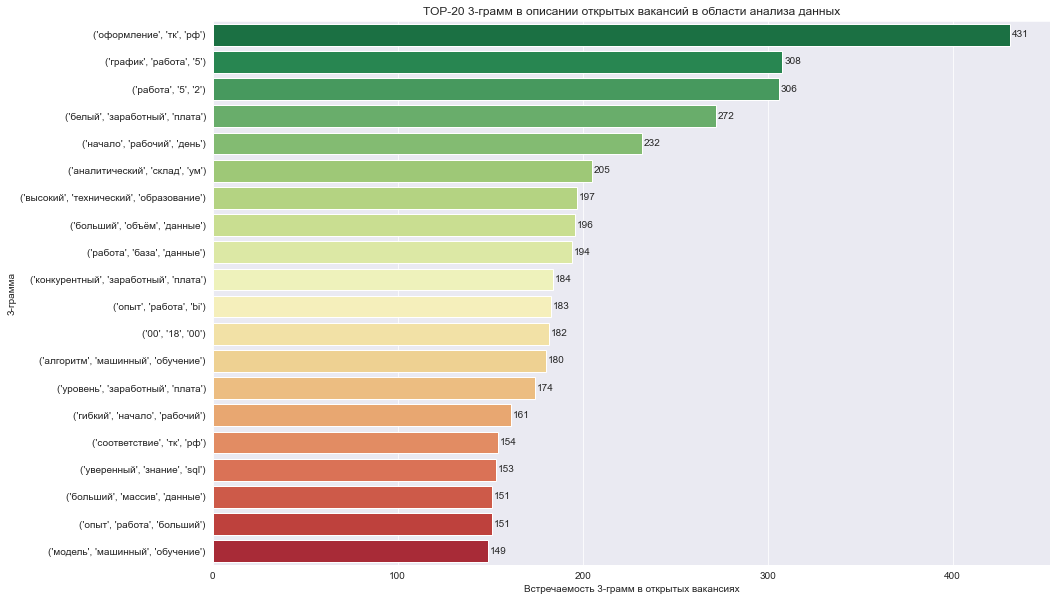

         1 место: ('оформление', 'тк', 'рф') (431)
         2 место: ('график', 'работа', '5') (308)
         3 место: ('работа', '5', '2') (306)
         4 место: ('белый', 'заработный', 'плата') (272)
         5 место: ('начало', 'рабочий', 'день') (232)
         6 место: ('аналитический', 'склад', 'ум') (205)
         7 место: ('высокий', 'технический', 'образование') (197)
         8 место: ('больший', 'объём', 'данные') (196)
         9 место: ('работа', 'база', 'данные') (194)
        10 место: ('конкурентный', 'заработный', 'плата') (184)
        11 место: ('опыт', 'работа', 'bi') (183)
        12 место: ('00', '18', '00') (182)
        13 место: ('алгоритм', 'машинный', 'обучение') (180)
        14 место: ('уровень', 'заработный', 'плата') (174)
        15 место: ('гибкий', 'начало', 'рабочий') (161)
        16 место: ('соответствие', 'тк', 'рф') (154)
        17 место: ('уверенный', 'знание', 'sql') (153)
        18 место: ('больший', 'массив', 'данные') (151)
        19 место

In [116]:
tmp = Counter([ngram for ngram in data['good_key_phrases_3grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common(20))
draw_barplot(1, 0, cnt_data, 
             title="TOP-20 3-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 3-грамм в открытых вакансиях", 
             ylabel="3-грамма")

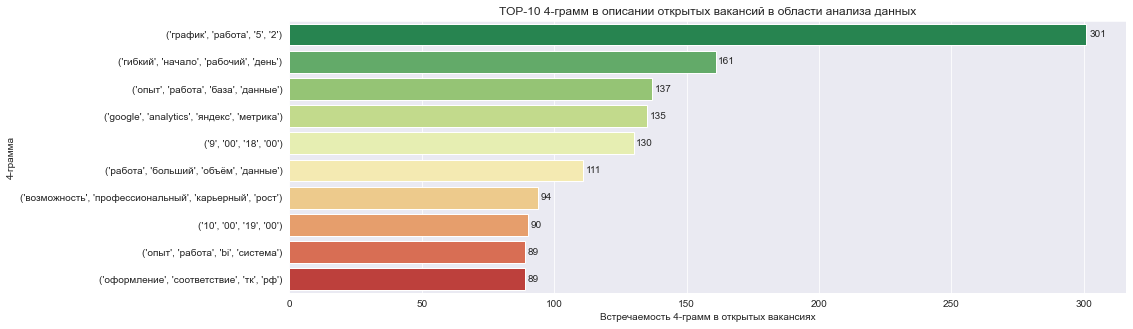

         1 место: ('график', 'работа', '5', '2') (301)
         2 место: ('гибкий', 'начало', 'рабочий', 'день') (161)
         3 место: ('опыт', 'работа', 'база', 'данные') (137)
         4 место: ('google', 'analytics', 'яндекс', 'метрика') (135)
         5 место: ('9', '00', '18', '00') (130)
         6 место: ('работа', 'больший', 'объём', 'данные') (111)
         7 место: ('возможность', 'профессиональный', 'карьерный', 'рост') (94)
         8 место: ('10', '00', '19', '00') (90)
         9 место: ('опыт', 'работа', 'bi', 'система') (89)
        10 место: ('оформление', 'соответствие', 'тк', 'рф') (89)


In [117]:
tmp = Counter([ngram for ngram in data['good_key_phrases_4grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common(10))
draw_barplot(1, 0, cnt_data, 
             title="TOP-10 4-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 4-грамм в открытых вакансиях", 
             ylabel="4-грамма")

## TOP JOB NAMES

In [118]:
def get_words_only(text):
    return re.sub(' +', ' ', re.sub('[^a-zа-я0-9]', ' ', text.lower())).lower()

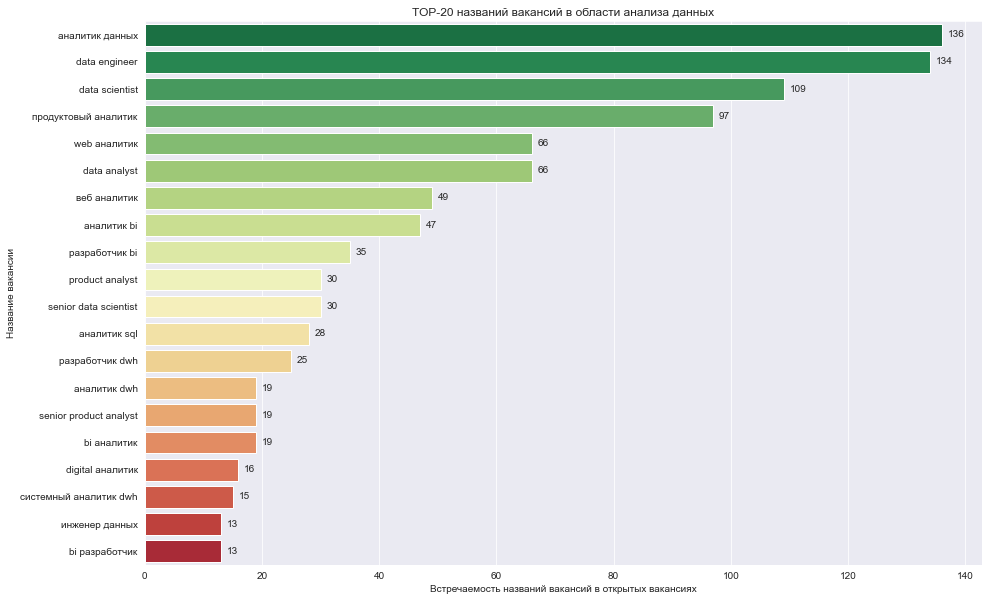

         1 место: аналитик данных (136)
         2 место: data engineer (134)
         3 место: data scientist (109)
         4 место: продуктовый аналитик (97)
         5 место: web аналитик (66)
         6 место: data analyst (66)
         7 место: веб аналитик (49)
         8 место: аналитик bi (47)
         9 место: разработчик bi (35)
        10 место: product analyst (30)
        11 место: senior data scientist (30)
        12 место: аналитик sql (28)
        13 место: разработчик dwh (25)
        14 место: аналитик dwh (19)
        15 место: senior product analyst (19)
        16 место: bi аналитик (19)
        17 место: digital аналитик (16)
        18 место: системный аналитик dwh (15)
        19 место: инженер данных (13)
        20 место: bi разработчик (13)


In [119]:
all_job_names = [name for name in list(data['name'].apply(get_words_only))]
cnt = Counter(list(all_job_names)).most_common(20)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="TOP-20 названий вакансий в области анализа данных", 
             xlabel="Встречаемость названий вакансий в открытых вакансиях", 
             ylabel="Название вакансии")

## BILLING TYPE

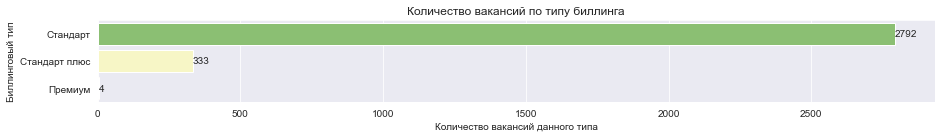

         1 место: Стандарт (2792)
         2 место: Стандарт плюс (333)
         3 место: Премиум (4)


In [120]:
cnt = Counter(list(data.billing_type_name)).most_common(3)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу биллинга", 
             xlabel="Количество вакансий данного типа", 
             ylabel="Биллинговый тип")

### Какой тип биллинга в вакансиях топ-10 компаний

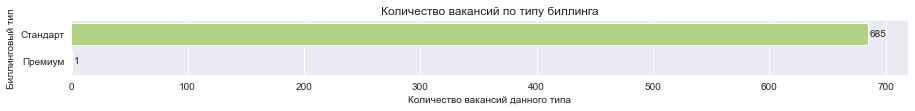

         1 место: Стандарт (685)
         2 место: Премиум (1)


In [121]:
grp = data[~data.open_vacancies.isna()]
emp_names = grp.groupby(['employer_id', 'employer_name']).agg({'id':'count','open_vacancies':'max'}).\
                                        reset_index().sort_values(by="id", ascending=False)[:10]['employer_name']

cnt = Counter(list(data[data.employer_name.isin(emp_names)]['billing_type_name'])).most_common(3)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу биллинга", 
             xlabel="Количество вакансий данного типа", 
             ylabel="Биллинговый тип")

In [122]:
prem_row = data[(data.employer_name=="Сбербанк") & (data.billing_type_name=="Премиум")].iloc[0]
print(prem_row.employer_name)
print(prem_row["name"])
print(f'Ключевые навыки: {prem_row.key_skills}')
print('Стек технологий: ', end="") 
print(", ".join(prem_row.tech_stack))
print('\nКлючевые фразы:')
print(", ".join(prem_row.desc_sentences).replace(", ", "\n"))

Сбербанк
Разработка витрин в Облаке Данных(Data Engineer)
Ключевые навыки: []
Стек технологий: v, greenplum, hadoop, c, scala, d, teradata, java, r, tera, kafka

Ключевые фразы:
обязанность
разработка поддержка витрина данные облако данные использоваться sql java scala
вывод витрина промышленный эксплуатация
настройка потоковый передача данные витрина ппрба использование kafka
управление качество данные
требование
опыт работа mpp рсубд greenplum teradata
отличный знание sql аналитический функция подзапрос хранить процедура оптимизация запрос
знание java scala
понимание принцип etl процесс
опыт коммерческий разработка витрина данные дальнейший вывод пром
опыт работа стек hadoop
опыт работа c kafka желательно
опыт работа инструмент организация оптимизация работа git confluence jira alm devops
желательно
условие
работа крупный банк россия
трудоустройство согласно тк рф
регулярный корпоративный обучение
дмс страхование несчастный случай тяжёлый заболевание
материальный помощь социальный по

In [123]:
premium_employers = set(data[data.billing_type_name=="Премиум"]['employer_name'])
", ".join(str(item) for item in premium_employers)

'Engine, Сбербанк, Makita, ЛК Сименс Финанс'

Удаляем мало полезные данные billing_type_name:

In [124]:
data.drop(columns="billing_type_name", inplace=True)

## EMPLOYMENT

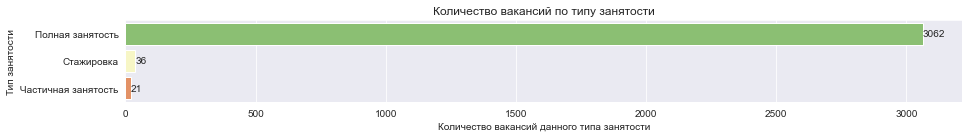

         1 место: Полная занятость (3062)
         2 место: Стажировка (36)
         3 место: Частичная занятость (21)


In [125]:
cnt = Counter(list(data.employment_name)).most_common(3)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу занятости", 
             xlabel="Количество вакансий данного типа занятости", 
             ylabel="Тип занятости")

In [126]:
intern_employers = set(data[data.employment_name=="Стажировка"]['employer_name'])
", ".join(str(item) for item in intern_employers)

'Т1 Консалтинг, Uchi.ru, SAP, Ozon, Tefal, Procter & Gamble, WorldQuant, Publicis Groupe, The Boston Consulting Group, BOSCH, Банк Хоум Кредит, Билайн, МАЙНДСЭТ, EY (Эрнст энд Янг), UniCredit Bank, ОТП Банк, АО (OTP bank), Gett, Леруа Мерлен, Сбербанк, Домашенко Валерий Юрьевич, САС Институт, сектор образовательных и тренировочных программ, Инфосистемы Джет, Align Technology, СИБУР, Группа компаний'

In [127]:
intern_employers = set(data[data.employment_name=="Частичная занятость"]['employer_name'])
", ".join(str(item) for item in intern_employers)

'Простой маркетинг, Полещук Дмитрий Сергеевич, Mail IQ (ИП Косенко А. В), ХакерЮ, Zebrainy Limited, NXP Semiconductors, SkillExpert, Ozon, Skillbox, GeekBrains, Skyeng, Яндекс.Практикум, Омнимикс, Гудфокаст, Отус, Даблби'

## SALARY TO RUR

In [128]:
data.salary_currency.unique()

array([nan, 'RUR', 'USD', 'EUR'], dtype=object)

In [129]:
RUR = 1.0
KZT = 0.18
UAH = 2.67
USD = 74.69
BYR = 28.67
EUR = 90.3
UZS = 0.0071


def func(num, condition):
    if pd.isnull(num):
        return None
    else:
        divider = {
            'RUR': RUR, 
            'KZT': KZT, 
            'UAH': UAH, 
            'USD': USD, 
            'BYR': BYR, 
            'EUR': EUR,  
            'UZS': UZS,
        }
        return num * divider[condition]

In [130]:
data['salary_from_RUR'] = data.apply(lambda x: func(x['salary_from'], x['salary_currency']), axis=1)
data['salary_to_RUR'] = data.apply(lambda x: func(x['salary_to'], x['salary_currency']), axis=1)

## Опыт работы

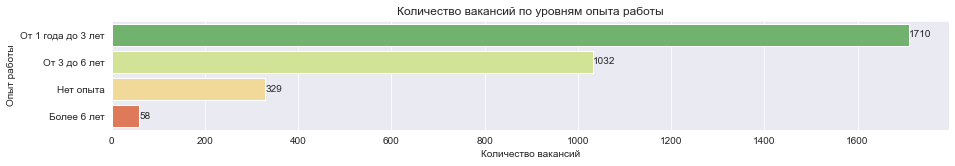

         1 место: От 1 года до 3 лет (1710)
         2 место: От 3 до 6 лет (1032)
         3 место: Нет опыта (329)
         4 место: Более 6 лет (58)


In [131]:
cnt = Counter(list(data.experience_name)).most_common(5)
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по уровням опыта работы", 
             xlabel="Количество вакансий", 
             ylabel="Опыт работы")

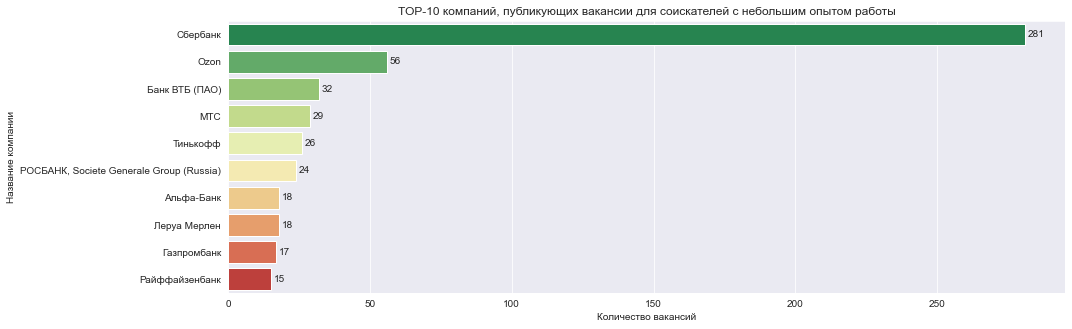

         1 место: Сбербанк (281)
         2 место: Ozon (56)
         3 место: Банк ВТБ (ПАО) (32)
         4 место: МТС (29)
         5 место: Тинькофф (26)
         6 место: РОСБАНК, Societe Generale Group (Russia) (24)
         7 место: Альфа-Банк (18)
         8 место: Леруа Мерлен (18)
         9 место: Газпромбанк (17)
        10 место: Райффайзенбанк (15)


In [132]:
grp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)[:10]

draw_barplot("cnt", "employer_name", grp, 
             title="TOP-10 компаний, публикующих вакансии для соискателей с небольшим опытом работы", 
             xlabel="Количество вакансий", 
             ylabel="Название компании")

<Figure size 1080x360 with 0 Axes>

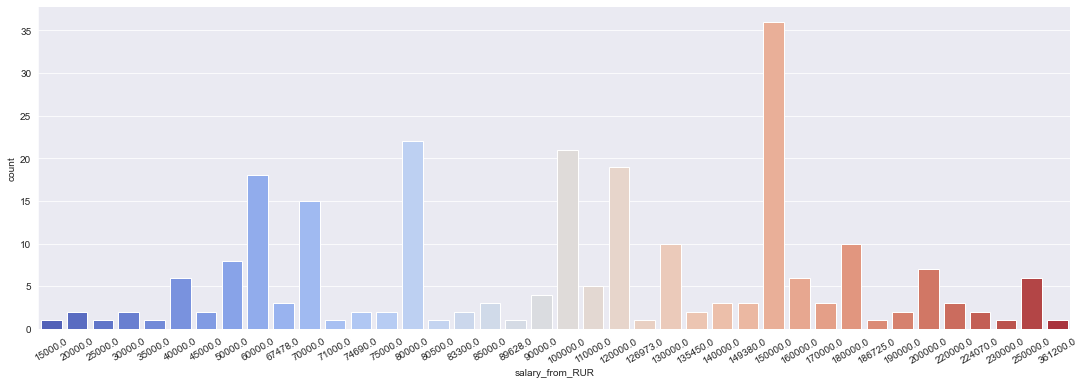

In [133]:
tmp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])][['id','salary_from_RUR']]

plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.catplot(x="salary_from_RUR", kind="count", palette="coolwarm", data=tmp, aspect=3)
g.set_xticklabels(rotation=30)

plt.show()

<Figure size 1080x360 with 0 Axes>

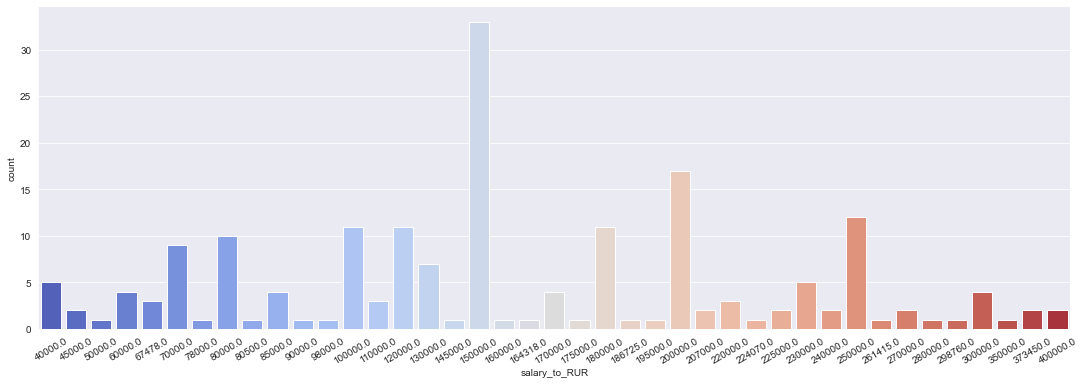

In [134]:
tmp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])][['id','salary_to_RUR']]

plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.catplot(x="salary_to_RUR", kind="count", palette="coolwarm", data=tmp, aspect=3)
g.set_xticklabels(rotation=30)

plt.show()

In [135]:
data.salary_gross.unique()

array([nan, 0.0, 1.0], dtype=object)

In [136]:
data.iloc[0]

address_lat                                                                 999.00
address_lng                                                                 999.00
address_metro_lat                                                            55.76
address_metro_line_name                                 Таганско-Краснопресненская
address_metro_lng                                                            37.58
address_metro_station_name                                             Баррикадная
address_metro_stations           [{'station_name': 'Баррикадная', 'line_name': ...
address_raw                                                                   None
alternate_url                                       https://hh.ru/vacancy/42193368
apply_alternate_url              https://hh.ru/applicant/vacancy_response?vacan...
area_name                                                                   Москва
branded_description              \n<style>\n.tmpl_hh_wrapper p,\n.tmpl_hh_wrapp...
crea

## POSITION GRADES

In [137]:
# def cond(row, text):
#     return text in row.lower()
def cond(row, text):
    return any(word in row.lower() for word in text)

In [138]:
all_titles = [string for string in data_extended['name'].apply(get_words_only)]
all_titles = flatten_lol([word.lower().split(' ') for word in all_titles])
cnt = Counter(all_titles).most_common(500)
cnt_data = pd.DataFrame(cnt)
cnt_data

,0,1
0,data,2841
1,аналитик,2426
2,,1711
3,engineer,1077
4,analyst,1013
5,scientist,991
6,данных,983
7,bi,757
8,разработчик,545
9,senior,464


In [139]:
data_extended['grade'] = None
heads = ["начальник","руководитель","главный","principal","head","lead","лид","лидер","директор","director","тимлид",
               "chief"] 
seniors = ["senior","sen","сен","сеньор","ведущий","expert","эксперт"]
mids = ["mid","middle","старший"]
juns = ["начинающий","младший","junior","jun"]
interns = ["internship","intern","стажёр","стажер","стажировка"]



for index, row in data_extended.iterrows():
    r = row["name"]
    if cond(r, heads):
        data_extended.at[index, "grade"] = "lead"
    elif ((cond(r, seniors)) & (cond(r, mids)) & (cond(r, juns))):
        data_extended.at[index, "grade"] = "junior middle senior"
    elif ((cond(r, seniors)) & (cond(r, mids))):
        data_extended.at[index, "grade"] = "middle senior"        
    elif ((cond(r, mids)) & (cond(r, juns))):
        data_extended.at[index, "grade"] = "junior middle"
    elif cond(r, seniors):
        data_extended.at[index, "grade"] = "senior"
    elif cond(r, mids):
        data_extended.at[index, "grade"] = "middle"        
    elif cond(r, juns):
        data_extended.at[index, "grade"] = "junior"
    elif cond(r, interns):
        data_extended.at[index, "grade"] = "intern"        

In [140]:
data_extended.groupby(['grade'])['grade'].count()

grade
intern                   69
junior                  164
junior middle            13
junior middle senior      7
lead                    329
middle                  198
middle senior           105
senior                  483
Name: grade, dtype: int64

In [141]:
data_extended.loc[data_extended['grade']=='intern', 'grade'] = 'junior'
data_extended.loc[data_extended['grade']=='junior middle', 'grade'] = 'middle'
data_extended.loc[data_extended['grade']=='junior middle senior', 'grade'] = 'middle'
# data_extended.loc[data_extended['grade']=='middle senior', 'grade'] = 'senior'
data_extended.groupby(['grade'])['grade'].count()

grade
junior           233
lead             329
middle           218
middle senior    105
senior           483
Name: grade, dtype: int64

## SALARY + RANK

In [142]:
data_extended.salary_currency.unique()

array([nan, 'KZT', 'RUR', 'UAH', 'EUR', 'USD', 'BYR', 'UZS'], dtype=object)

In [143]:
RUR = 1.0
KZT = 0.18
UAH = 2.67
USD = 74.69
BYR = 28.67
EUR = 90.3
UZS = 0.0071


def func(num, condition):
    if pd.isnull(num):
        return None
    else:
        divider = {
            'RUR': RUR, 
            'KZT': KZT, 
            'UAH': UAH, 
            'USD': USD, 
            'BYR': BYR, 
            'EUR': EUR,  
            'UZS': UZS,
        }
        return num * divider[condition]

In [144]:
data_extended['salary_from_RUR'] = data_extended.apply(lambda x: func(x['salary_from'], x['salary_currency']), axis=1)
data_extended['salary_to_RUR'] = data_extended.apply(lambda x: func(x['salary_to'], x['salary_currency']), axis=1)

In [145]:
data_graph = data_extended[(data_extended['area_name']=="Москва") &
                           ((data_extended['salary_from_RUR']!=None) | (data_extended['salary_to_RUR']!=None))
                          ][['grade', 'salary_from_RUR', 'salary_to_RUR']]

<AxesSubplot:xlabel='salary_from_RUR', ylabel='grade'>

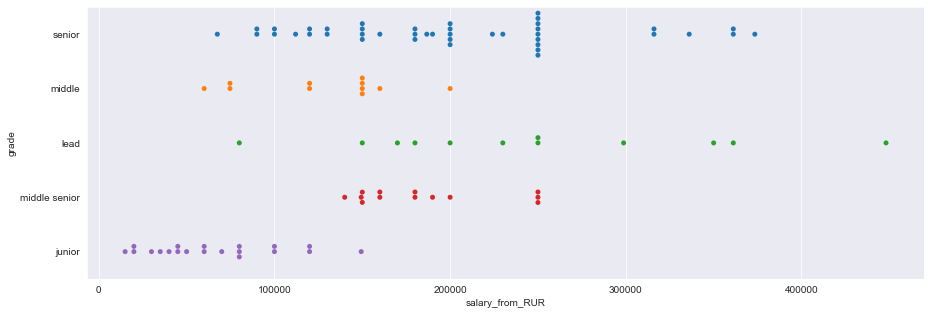

In [146]:
plt.figure(figsize=(15,5))
sns.swarmplot(x="salary_from_RUR", y="grade", data=data_graph)

In [147]:
# jun_up_threshold = data_graph[data_graph["rank"]=="middle"]["salary_from_RUR"].min()
jun_up_threshold = 100000
# sen_low_threshold = data_graph[data_graph["rank"]=="middle"]["salary_from_RUR"].max()
# sen_low_threshold = 250000
# mid_low_threshold = data_graph[(data_graph["rank"]=="junior") &
#                               (data_graph["salary_from_RUR"]<200000)]["salary_from_RUR"].max()
# mid_up_threshold = data_graph[(data_graph["rank"]=="senior") &
#                               (data_graph["salary_from_RUR"]>140000)]["salary_from_RUR"].min()

# print(f"Зарплаты junior: до {jun_up_threshold}")
# print(f"Зарплаты senior: от {sen_low_threshold}")
# print(f"Зарплаты middle: от {mid_low_threshold} до {mid_up_threshold}")

In [148]:
data_extended.loc[(data_extended["grade"].isnull()) & 
                  (data_extended['salary_from_RUR']<jun_up_threshold), 'grade'] = 'junior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_from_RUR']>sen_low_threshold), 'rank'] = 'senior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_from_RUR']>mid_low_threshold) &
#                   (data_extended['salary_from_RUR']<mid_up_threshold), 'rank'] = 'middle'
data_extended.groupby(['grade'])['grade'].count()

grade
junior           518
lead             329
middle           218
middle senior    105
senior           483
Name: grade, dtype: int64

In [149]:
data_graph = data_extended[(data_extended['area_name']=="Москва") &
                           ((data_extended['salary_from_RUR']!=None) | (data_extended['salary_to_RUR']!=None))
                          ][['grade', 'salary_from_RUR', 'salary_to_RUR']]

<AxesSubplot:xlabel='salary_to_RUR', ylabel='grade'>

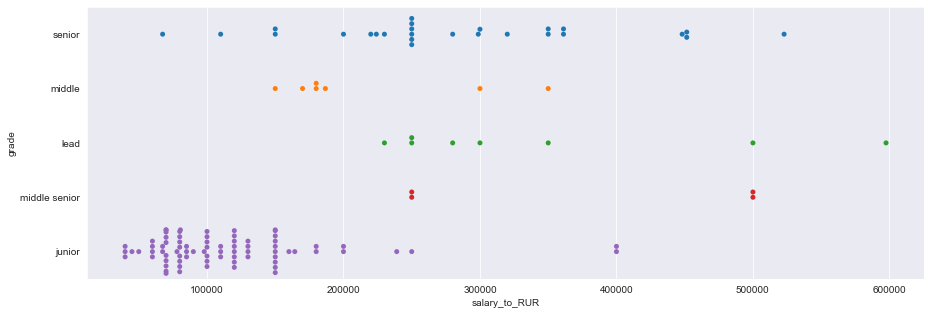

In [150]:
plt.figure(figsize=(15,5))
sns.swarmplot(x="salary_to_RUR", y="grade", data=data_graph)

In [151]:
jun_up_threshold = data_graph[data_graph["grade"]=="senior"]["salary_to_RUR"].min()
# jun_up_threshold = 150000
jun_up_threshold

67478.0

In [152]:
# sen_low_threshold = data_graph[(data_graph["rank"]=="middle") &
#                               (data_graph["salary_to_RUR"]<300000)]["salary_to_RUR"].max()
# sen_low_threshold

In [153]:
data_extended.loc[(data_extended["grade"].isnull()) & 
                  (data_extended['salary_to_RUR']<jun_up_threshold), 'rank'] = 'junior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_to_RUR']>sen_low_threshold), 'rank'] = 'senior'
data_extended.loc[(data_extended['grade']!='junior') & (~data_extended['grade'].isna()), 'grade'] = 'not junior'

data_extended.groupby(['grade'])['grade'].count()

grade
junior         518
not junior    1135
Name: grade, dtype: int64

In [154]:
# def get_requirements(text, corpus, is_words=False):
#     tmp = [list(elem) for elem in text.keys()]
#     if is_words:     
#         return [key for key in tmp if key[0] in corpus]
#     else:
#         return [key for key in tmp if key in corpus]

In [155]:
# data_extended['req_words'] = data_extended['word_counts'].apply(get_requirements, corpus=corpus_words, is_words=True)
# data_extended['req_bigrams'] = data_extended['bigram_counts'].apply(get_requirements, corpus=corpus_bigrams)
# data_extended['req_trigrams'] = data_extended['trigram_counts'].apply(get_requirements, corpus=corpus_trigrams)
# data_extended['req_fourgrams'] = data_extended['fourgram_counts'].apply(get_requirements, corpus=corpus_fourgrams)

In [156]:
def flatten_list_of_lists(text):
#     return [elem for elem in text for elem in elem]
    return " ".join([elem for elem in text for elem in elem])

def list_to_string(text):
#     return [elem for elem in text for elem in elem]
    return " ".join([elem for elem in text])

In [157]:
data_categorized = data_extended[~data_extended["grade"].isna()][['grade',
                                                                 'good_key_phrases_2grams','good_key_phrases_3grams' ,
                                                                 'good_key_phrases_4grams','good_key_phrases_5grams',
                                                                 'good_key_phrases_6grams','tech_stack',
                                                                 ]]

In [158]:
data_categorized['good_key_phrases_2grams'] = data_categorized['good_key_phrases_2grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_3grams'] = data_categorized['good_key_phrases_3grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_4grams'] = data_categorized['good_key_phrases_4grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_5grams'] = data_categorized['good_key_phrases_5grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_6grams'] = data_categorized['good_key_phrases_6grams'].apply(flatten_list_of_lists)
data_categorized['tech_stack'] = data_categorized['tech_stack'].apply(list_to_string)

In [159]:
data_categorized.iloc[0]['good_key_phrases_3grams'] 

'работа база данные реляционный база данные опыт анализ данные постановка задача разработчик'

In [160]:
# data_categorized['experience_name'] = data_categorized.experience_name.apply(preprocess_text)
# data_categorized['employment_name'] = data_categorized.employment_name.apply(preprocess_text)

In [161]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','good_key_phrases_3grams' ,
                                                                 'good_key_phrases_4grams','good_key_phrases_5grams',
                                                                 'good_key_phrases_6grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)
# data_categorized['text'] = data_categorized['desc_lemm']


In [162]:
data_categorized.iloc[0]['text'] 

'etl процесс технический задание программный обеспечение анализ данные навык работа работа sql работа база база данные данные знание реляционный база язык sql sql запрос знание основный опыт анализ данные построение построение модель бизнес анализ желательно знание знание методология предметный область обратный связь постановка задача задача разработчик бизнес требование работа база данные реляционный база данные опыт анализ данные постановка задача разработчик    v hadoop spark c scala анализ данные postgres d ml clickhouse java r'

In [177]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','good_key_phrases_3grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)

In [178]:
from collections import defaultdict

In [179]:
words_count = defaultdict(lambda: 0)

for text in data_categorized.text:
    for word in text:
        words_count[word] +=1
        
len(words_count)

69

In [180]:
top_words = 1000   # ограниичимся словарём из 1000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

data_categorized['freq_text'] = data_categorized.text.apply(freq_filter)

In [181]:
data_categorized = data_categorized[data_categorized.freq_text.apply(len) > 1]

In [182]:
ranks = list(set(data_categorized['grade']))
ranks

['not junior', 'junior']

In [183]:
from sklearn import preprocessing

In [184]:
le = preprocessing.LabelEncoder()
rank_encode = le.fit_transform(ranks)
rank_encoder = dict(zip(ranks, rank_encode))
rank_encoder

{'not junior': 1, 'junior': 0}

In [185]:
data_categorized['grade'] = data_categorized['grade'].map(rank_encoder)

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(data_categorized["freq_text"], 
                                                    data_categorized["grade"], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [188]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# как выглядит вектор
# X_train.iloc[25][:300]

1239 train sequences
414 test sequences


## Классификация грейда вакансий с TF

In [189]:
import tensorflow as tf

In [190]:
# слои для нейронок, которые нам пригодятся 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [191]:
max_text_length = 1000         

X_train = sequence.pad_sequences(X_train, maxlen=max_text_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_text_length)

In [192]:
NEIRONS = len(ranks)
embedding_vector_length = 64    # размерность эмбендинга
top = top_words + 1             # на вход идут слова и нулевой элемент

adam = tf.keras.optimizers.Adam(
    learning_rate=0.01, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07, 
    amsgrad=False,
    name='Adam',
)

In [193]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_text_length))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
# model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dense(NEIRONS, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [194]:

with tf.device('/CPU:0'):
    hist = model.fit(X_train, y_train, validation_split=0.15, epochs=6, batch_size=40)

Epoch 1/6
27/27 [==============================] - 6s 142ms/step - loss: 0.6710 - accuracy: 0.6052 - val_loss: 0.6309 - val_accuracy: 0.6828
Epoch 2/6
27/27 [==============================] - 2s 88ms/step - loss: 0.6130 - accuracy: 0.6599 - val_loss: 0.6046 - val_accuracy: 0.6828
Epoch 3/6
27/27 [==============================] - 2s 85ms/step - loss: 0.5964 - accuracy: 0.6903 - val_loss: 0.6075 - val_accuracy: 0.7204
Epoch 4/6
27/27 [==============================] - 2s 90ms/step - loss: 0.5906 - accuracy: 0.6932 - val_loss: 0.5940 - val_accuracy: 0.7312
Epoch 5/6
27/27 [==============================] - 3s 99ms/step - loss: 0.5619 - accuracy: 0.7420 - val_loss: 0.5980 - val_accuracy: 0.7043
Epoch 6/6
27/27 [==============================] - 2s 88ms/step - loss: 0.5714 - accuracy: 0.7416 - val_loss: 0.5988 - val_accuracy: 0.6989


In [195]:
with tf.device('/CPU:0'):
    scores = model.evaluate(X_test, y_test, verbose=0)
    prob = model.predict_proba(X_test)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.7343


In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

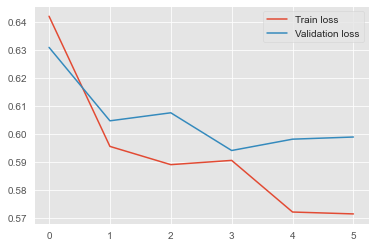

In [197]:

# когда начали переобучаться
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

## Классификация грейда вакансий с NaiveBayes

In [198]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
vectorizer = TfidfVectorizer(stop_words=stopwords)

In [199]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)
vectors = vectorizer.fit_transform(data_categorized["text"])

In [200]:
X_train, X_test, y_train, y_test = train_test_split(vectors, 
                                                    data_categorized["grade"], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [201]:
def fit_NBclassifier(trainset, trainlabel):
    nbclassifier = MultinomialNB()
    nbclassifier.fit(trainset, trainlabel)
    
    return nbclassifier

In [202]:
NB_clf = fit_NBclassifier(X_train, y_train)

In [203]:
label_predicted = NB_clf.predict(X_test)

In [204]:
accuracy = accuracy_score(y_test, label_predicted) # accuracy rate of the classifier
accuracy

0.7915407854984894